# Leanding Club Case Study

Imports and basic set-up

In [1]:
import warnings
from os import getcwd
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
# plt.style.use('seaborn-v0_8-pastel')

In [3]:
PRJ_DIR = getcwd()
DATA_DIR = join(PRJ_DIR, 'data')

## Step 0: Reading data

In [4]:
df = pd.read_csv(join(DATA_DIR, 'loan.csv'))
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [5]:
data_dict = pd.read_excel(join(DATA_DIR, 'Data_Dictionary.xlsx'))
data_dict = data_dict.dropna()
data_dict.sample(5)

,LoanStatNew,Description
72,num_tl_op_past_12m,Number of accounts opened in past 12 months
8,bc_open_to_buy,Total open to buy on revolving bankcards.
67,num_rev_tl_bal_gt_0,Number of revolving trades with balance >0
93,tax_liens,Number of tax liens
24,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.


## Step 1: Cleaning

### Choosing columns
There are columns with `Nan` values.

In [6]:
df.isna().sum()

id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          2459
emp_length                         1075
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              12942
purpose                               0
title                                11
zip_code                              0
addr_state                            0
dti                                   0


As seen above, there are columns which do not contain any values. Some of the columns contain not but few values.

In [7]:
(df.isna().sum() >= 0.6 * df.shape[0]).sum()

57

57 columns have more than 50% vlues as null. I am choosing not to use them and dropping them from analysis.

In [8]:
column_names = df.columns[df.isna().sum() <= 0.60 * df.shape[0]].tolist()
data_df = df[column_names]
del df
data_df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
35252,438794,529085,1675,1675,1675.0,36 months,7.74%,52.30,A,A3,Borders Group,7 years,RENT,20000.0,Not Verified,Sep-09,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=438794,I can't make a dent on my balance on this card because it has a really high interest rate.,credit_card,Amazon Credit Card,933xx,CA,4.68,0,May-01,0,6,0,2927,27.90%,7,f,0.0,0.0,1882.508944,1882.51,1675.0,207.51,0.0,0.0,0.0,Sep-12,53.46,Sep-12,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
29598,520433,672823,8000,8000,7900.0,36 months,6.76%,246.14,A,A2,Missouri Enterprise,2 years,MORTGAGE,64000.0,Not Verified,May-10,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=520433,Borrower added on 05/20/10 > We are having a destination wedding in Florida and need a short term loan to assist with expenses. We are excited to go through this process. I have an excellent credit history and payments made on time. I thank-you for your help in making this a great day for us.<br/>,wedding,Destination Wedding,641xx,MO,11.38,0,Feb-94,0,10,0,1664,5.50%,24,f,0.0,0.0,8739.749713,8630.50,8000.0,739.75,0.0,0.0,0.0,Sep-12,869.01,Aug-12,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
17629,712476,905581,24000,24000,24000.0,60 months,10.74%,518.72,B,B4,Jefferson County Engineer's Office,10+ years,RENT,102000.0,Source Verified,Mar-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=712476,NaN,debt_consolidation,Debt Restructure,439xx,OH,9.74,0,Dec-92,1,11,0,14931,67.90%,41,f,0.0,0.0,31122.537080,31122.54,24000.0,7122.54,0.0,0.0,0.0,Apr-16,518.05,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


Another thing to check in the remaining column is the numbeor of unique values found in the each column

In [9]:
data_df.nunique()

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26526
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths              

There are columns which contain only 1 value for all the rows. We are choosing not to use them either as they are not adding any information wrt to our target variable

In [10]:
(data_df.nunique() <= 1).sum()

9

9 columns will be additionally removed from our analysis.

In [11]:
column_names = data_df.columns[data_df.nunique() > 1]
data_df = data_df[column_names]
data_df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
10638,829807,1038931,4000,4000,4000.0,36 months,12.99%,134.76,C,C1,First American Title,9 years,MORTGAGE,75000.0,Source Verified,Jul-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=829807,Borrower added on 07/25/11 > This loan is to pay for a new transmission on my 2005 Chevy Silverado.<br/>,other,Truck Transmission,925xx,CA,1.33,0,Feb-01,1,5,0,1325,36.80%,11,0.0,0.0,4851.208773,4851.21,4000.00,851.21,0.0,0.0,0.0,Aug-14,140.35,Aug-14,0.0
32739,478353,607301,6000,6000,5975.0,36 months,14.26%,205.84,C,C5,mill creek mechanical,< 1 year,RENT,20800.0,Not Verified,Jan-10,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=478353,Borrower added on 01/20/10 > 1st home<br/>,major_purchase,Buying 1st home,236xx,VA,0.87,0,Oct-04,0,2,0,422,7.70%,3,0.0,0.0,7449.175094,7418.14,6000.00,1404.18,45.0,0.0,0.0,Jan-13,361.10,Feb-13,0.0
18317,699300,890845,26000,26000,25925.0,60 months,18.99%,674.32,F,F3,IBM,10+ years,MORTGAGE,60000.0,Verified,Mar-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=699300,NaN,debt_consolidation,My Debt Consolidation Loan,301xx,GA,10.90,0,Aug-00,0,7,0,16989,81.70%,26,0.0,0.0,10787.360000,10756.41,4729.52,6057.84,0.0,0.0,0.0,Aug-12,38.13,May-16,0.0


In [12]:
column_desc_df = pd.DataFrame([(i, data_df[i].isna().sum(),
                                data_df[i].nunique(),
                                data_dict[data_dict.LoanStatNew == i]['Description'].values[0])
                               for i in data_df.columns],
                              columns=['Column_Name', 'Num_NAs',
                                       'Num_unique_vals', 'Description'])
column_desc_df

,Column_Name,Num_NAs,Num_unique_vals,Description
0,id,0,39717,A unique LC assigned ID for the loan listing.
1,member_id,0,39717,A unique LC assigned Id for the borrower member.
2,loan_amnt,0,885,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,0,1041,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,0,8205,The total amount committed by investors for that loan at that point in time.
5,term,0,2,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,0,371,Interest Rate on the loan
7,installment,0,15383,The monthly payment owed by the borrower if the loan originates.
8,grade,0,7,LC assigned loan grade
9,sub_grade,0,35,LC assigned loan subgrade


In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

In [14]:
def get_earliest_yr(x):
    x = int(x.split("-")[1])
    if 0 <= x <= 11:
        return str(2000 + x)
    return str(1900 + x)

In [15]:
data_df['term'] = data_df.term.apply(lambda x: int(x.strip().split(' ')[0]))
data_df['int_rate'] = data_df.int_rate.apply(lambda x: float(x.strip().strip('%')))

data_df['issue_d_month'] = data_df.issue_d.apply(lambda x: x.split('-')[0])
data_df['issue_d_year'] = data_df.issue_d.apply(lambda x: "20" + x.split('-')[1])

data_df['earliest_cr_line_month'] = data_df.earliest_cr_line.apply(lambda x: x.split('-')[0])
data_df['earliest_cr_line_year'] = data_df.earliest_cr_line.apply(get_earliest_yr)

data_df['last_pymnt_d_month'] = data_df.last_pymnt_d.apply(lambda x: x.split('-')[0] if isinstance(x, str) else x)
data_df['last_pymnt_d_year'] = data_df.last_pymnt_d.apply(lambda x: "20" + x.split('-')[1] if isinstance(x, str) else x)

data_df['last_credit_pull_d_month'] = data_df.last_credit_pull_d.apply(lambda x: x.split('-')[0] if isinstance(x, str) else x)
data_df['last_credit_pull_d_year'] = data_df.last_credit_pull_d.apply(lambda x: "20" + x.split('-')[1] if isinstance(x, str) else x)

data_df['emp_title'] = data_df.emp_title.apply(lambda x: x.strip().upper() if not isinstance(x, float) else x)
data_df['emp_length'] = data_df.emp_length.apply(lambda x: x if '<' not in str(x) else '<1 year')
data_df['revol_util'] = data_df.revol_util.apply(lambda x: float(x.strip("%")) if isinstance(x, str) else float(x))
data_df['title'] = data_df.title.apply(lambda x: x.strip().lower() if not isinstance(x, float) else x)

In [16]:
data_df = data_df.drop(['issue_d', 'earliest_cr_line', 'url', 'last_pymnt_d', 'last_credit_pull_d', 'desc'], axis=1)

## Step 2: Uni-variate Analysis

### Annual Income

In [17]:
data_df.annual_inc.describe()

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

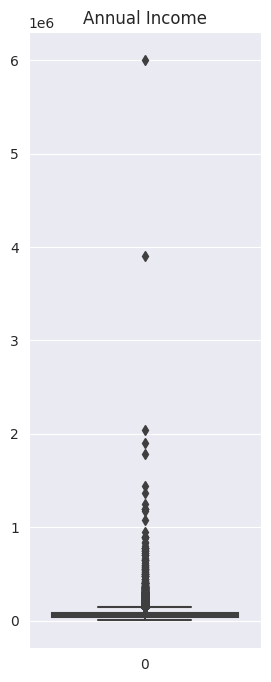

In [18]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.annual_inc)
plt.title('Annual Income')
plt.show()

Here we encounter some outliers. It is evident from the 5 point summary that 75% of the annual incomes are below USD 100K, but the highest income is USD 6M. Analyzing this columns while considering all the values would not yield correct results and therefore we choose drop rows where the annual income is greater than USD 150K.

In [19]:
data_df = data_df[(data_df.annual_inc <= 150_000)]
data_df.annual_inc.describe()

count     38166.000000
mean      62034.776686
std       29133.956592
min        4000.000000
25%       40000.000000
50%       57000.000000
75%       79200.000000
max      150000.000000
Name: annual_inc, dtype: float64

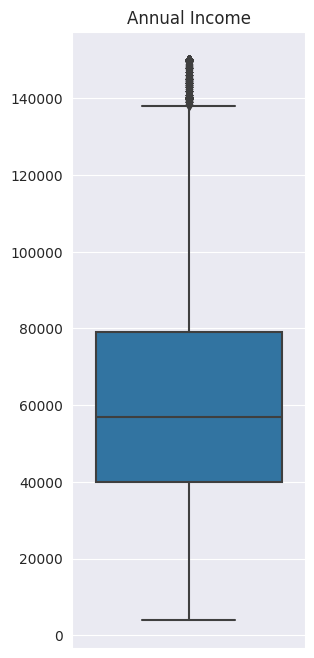

In [20]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.annual_inc)
plt.title('Annual Income')
plt.xticks(ticks=[])
plt.show()

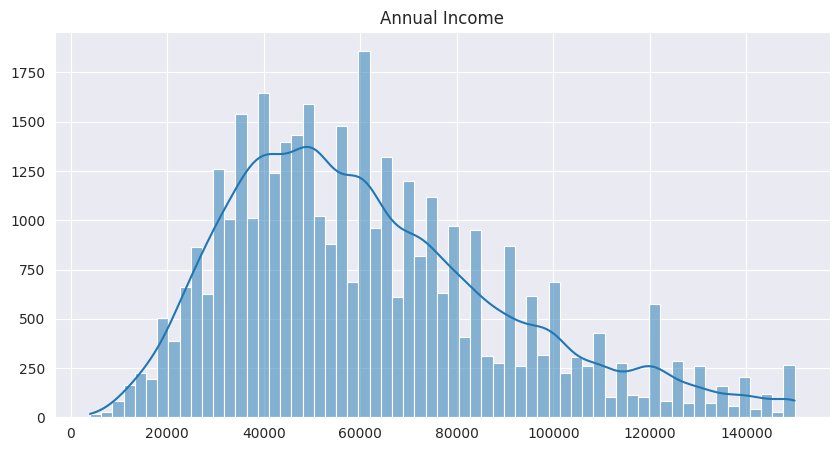

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.annual_inc, kde=True)
plt.title('Annual Income')
plt.xlabel("")
plt.ylabel("")
plt.show()

We observe that:
- The median annual income is USD 57K
- Income of most of the applicants lie below USD 80K

### Last Payment Amount

In [22]:
data_df.last_pymnt_amnt.describe()

count    38166.000000
mean      2591.608608
std       4300.622286
min          0.000000
25%        214.462500
50%        528.175000
75%       3201.652500
max      36115.200000
Name: last_pymnt_amnt, dtype: float64

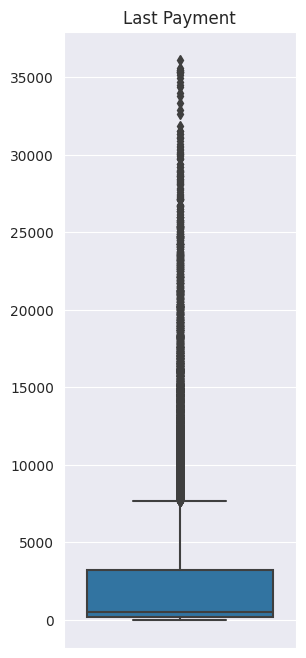

In [23]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.last_pymnt_amnt)
plt.title('Last Payment')
plt.xticks(ticks=[])
plt.show()

Here we encounter some outliers. It is evident from the 5 point summary that 75% of the loan payment amounts are around USD 3200, but the highest income is around USD 36K. Analyzing this columns while considering all the values would not yield correct results and therefore we choose drop rows where the annual income is greater than USD 150K.

In [24]:
data_df = data_df[(data_df.last_pymnt_amnt <= 8000)]
data_df.last_pymnt_amnt.describe()

count    34307.000000
mean      1394.188342
std       1905.199772
min          0.000000
25%        194.560000
50%        430.140000
75%       1919.680000
max       7998.750000
Name: last_pymnt_amnt, dtype: float64

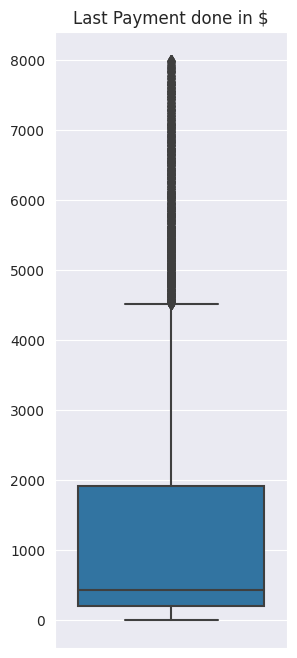

In [25]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.last_pymnt_amnt)
plt.title('Last Payment done in $')
plt.xticks(ticks=[])
plt.show()

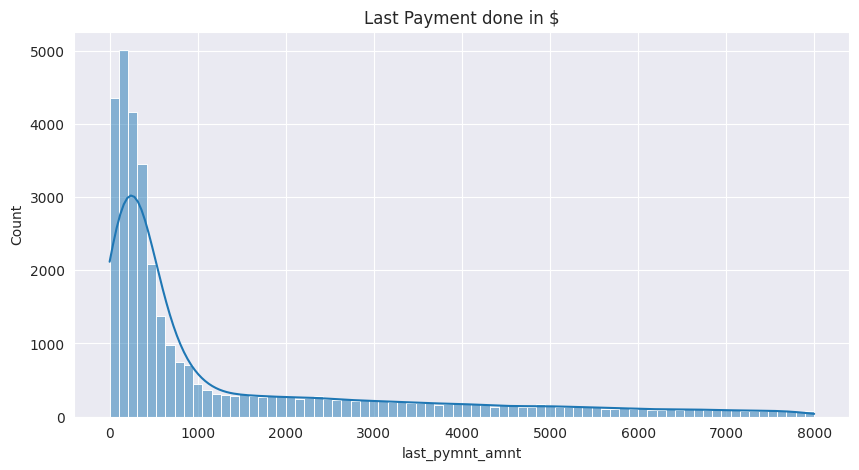

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.last_pymnt_amnt, kde=True)
plt.title('Last Payment done in $')
plt.show()

We observe that:
- More than 50% of the amount paid as the latest payment is less than $500

### Loan Status

In [27]:
data_df.loan_status.value_counts()

loan_status
Fully Paid     27777
Charged Off     5455
Current         1075
Name: count, dtype: int64

In [28]:
data_df = data_df[data_df.loan_status.isin(['Fully Paid', 'Charged Off'])]

In [29]:
data_df.loan_status.value_counts() / data_df.loan_status.value_counts().sum()

loan_status
Fully Paid     0.835851
Charged Off    0.164149
Name: count, dtype: float64

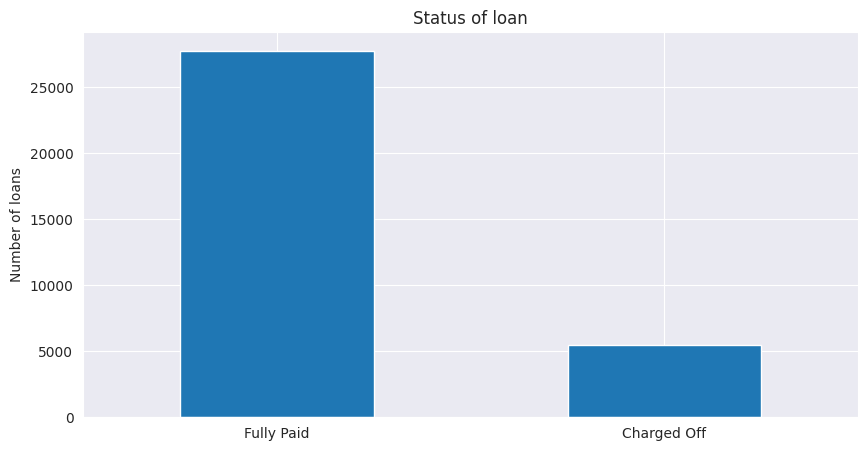

In [30]:
plt.figure(figsize=(10, 5))
data_df.loan_status.value_counts().plot.bar()
plt.title("Status of loan")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- More than **27K** loans have been fully paid
- **~5.5K** loans are actually bad loans i.e. the applicants defaulted

### Loan amount

In [31]:
data_df.loan_amnt.describe()

count    33232.000000
mean      9751.773893
std       6422.194941
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12800.000000
max      35000.000000
Name: loan_amnt, dtype: float64

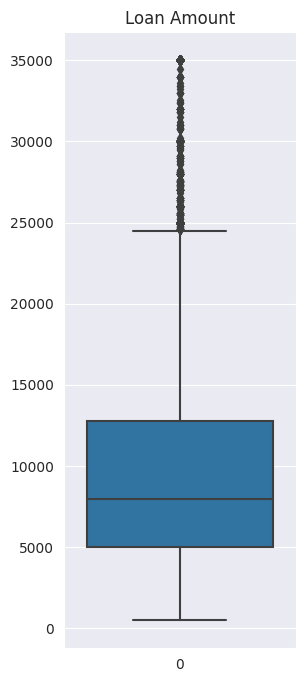

In [32]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.loan_amnt)
plt.title('Loan Amount')
plt.show()

We observe that:
- The median amount that is applied for is USD 8200
- Only 25% of the applicants have applied for amounts greater than USD 13000

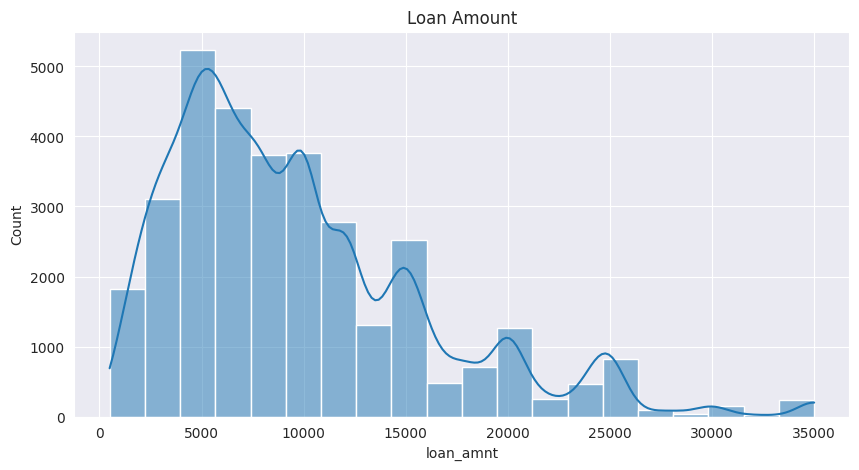

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.loan_amnt, bins=20, kde=True)
plt.title('Loan Amount')
plt.show()

### Funded Amount

In [34]:
data_df.funded_amnt.describe()

count    33232.000000
mean      9536.088710
std       6191.769515
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

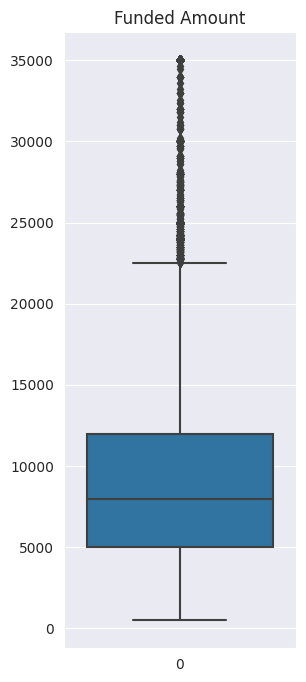

In [35]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.funded_amnt)
plt.title('Funded Amount')
plt.show()

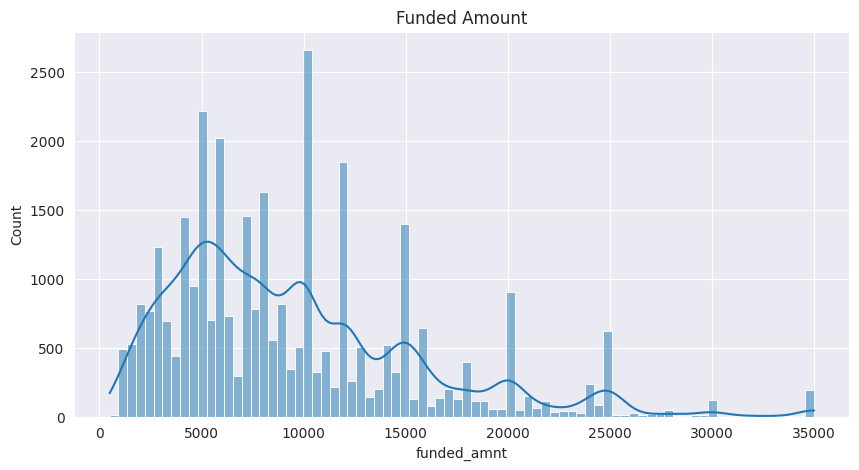

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.funded_amnt, kde=True)
plt.title('Funded Amount')
plt.show()

We observe that:
- The median amount that is funded by the club is approximately USD 8000

### Amount Funded by Investor

In [37]:
data_df.funded_amnt_inv.describe()

count    33232.000000
mean      9018.542587
std       6106.340451
min          0.000000
25%       4775.000000
50%       7775.000000
75%      12000.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

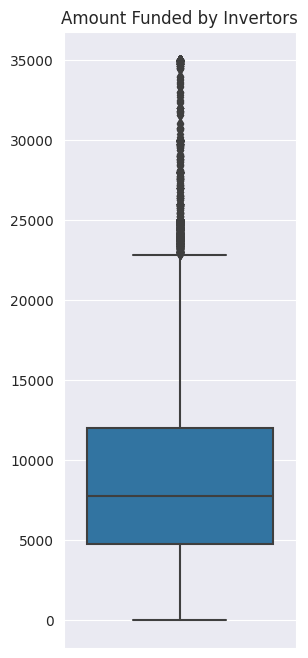

In [38]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.funded_amnt_inv)
plt.title('Amount Funded by Invertors')
plt.xticks(ticks=[])
plt.show()

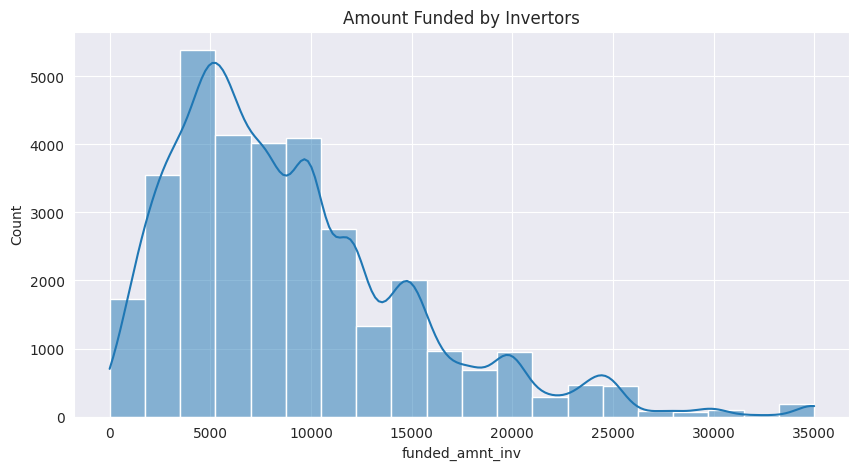

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.funded_amnt_inv, bins=20, kde=True)
plt.title('Amount Funded by Invertors')
plt.show()

We observe that:
- The median amount that is funded by the investors is a approximately USD 8000
- Only 25% of the loans have been funded for more than USD 12000

### Term of the loan

In [40]:
data_df.term.value_counts() / data_df.term.value_counts().sum()

term
36    0.791135
60    0.208865
Name: count, dtype: float64

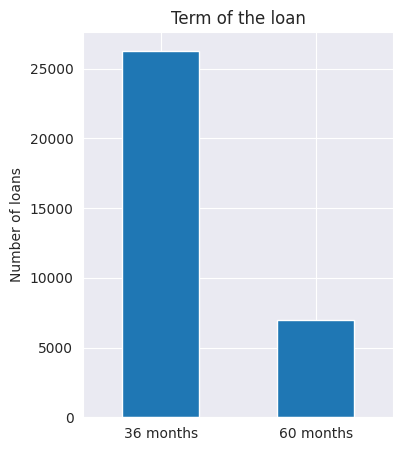

In [41]:
plt.figure(figsize=(4, 5))
data_df.term.value_counts().plot.bar()
plt.title("Term of the loan")
plt.xticks(ticks=[0 ,1], labels=['36 months', '60 months'], rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We have loans of 2 type of terms:
- 36 months or 3 years
- 60 months or 5 years

We observe that amount of loans issued for the 36 month period are far more than those issued for 60 month period.

### Interest Rates

In [42]:
data_df.int_rate.describe()

count    33232.000000
mean        11.700860
std          3.596542
min          5.420000
25%          8.880000
50%         11.490000
75%         14.170000
max         24.400000
Name: int_rate, dtype: float64

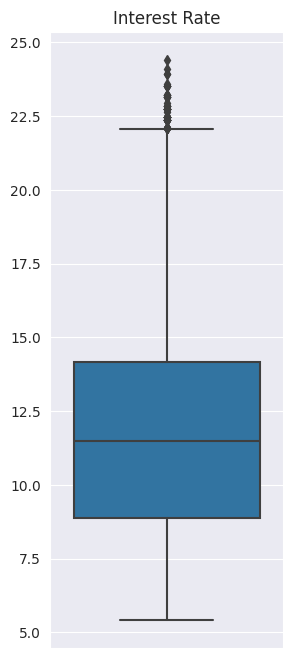

In [43]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.int_rate)
plt.title('Interest Rate')
plt.xticks(ticks=[])
plt.show()

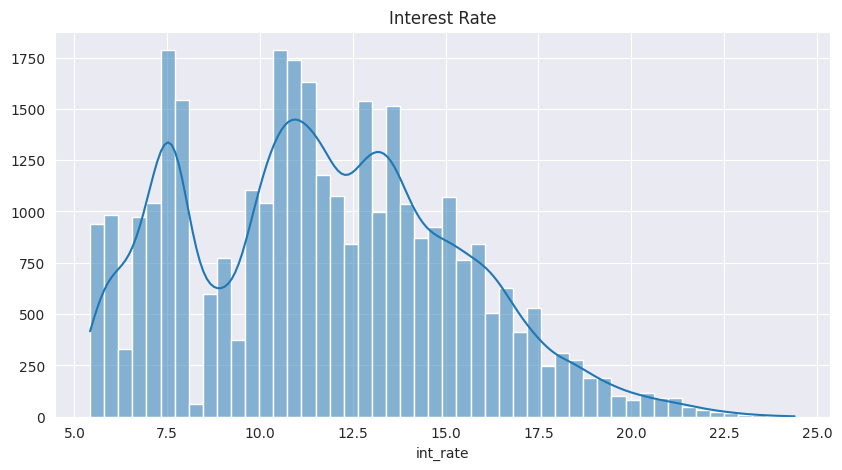

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.int_rate, bins=50, kde=True)
plt.title('Interest Rate')
plt.ylabel(None)
plt.show()

We observe that:
- **More than 75%** of the loans have an interest rate less than **15%**
- **50%** of the loans have an interest rate between ~**9%** and ~**14.25%** 

### Installments

In [45]:
data_df.installment.describe()

count    33232.000000
mean       289.513776
std        186.987542
min         15.690000
25%        155.560000
50%        248.080000
75%        375.402500
max       1305.190000
Name: installment, dtype: float64

We observe that:
- Median installment paid is **~USD 250**
- **More than 75%** of the monthly installments are **below USD 375**

### Grade and Sub-Grade

In [46]:
data_df.grade.value_counts().sort_index()

grade
A     9229
B    10057
C     6772
D     4308
E     1985
F      691
G      190
Name: count, dtype: int64

In [47]:
data_df.sub_grade.value_counts()

sub_grade
A4    2602
A5    2440
B3    2397
B5    2240
B4    2086
C1    1770
B2    1723
A3    1697
C2    1651
B1    1611
A2    1421
C3    1298
D2    1100
A1    1069
C4    1048
C5    1005
D3     941
D1     843
D4     755
D5     669
E1     563
E2     462
E3     390
E4     307
E5     263
F1     217
F2     165
F3     113
F4     109
F5      87
G1      60
G2      53
G3      31
G4      30
G5      16
Name: count, dtype: int64

We observe that:
- Most of the loans are **Grade B**, followed by **A**, and **C**
- Most of the loans are of sub-grade **A4** followed by **B3**, and **A5**

### Employee Title

> **NOTE**: The values of this columns are text. We observe that values indicating same employer name are repeated in different cases, and spellings. We tackled the case earlier by converting every value to upper case. 

In [48]:
data_df.emp_title.value_counts()[:10]

emp_title
US ARMY              176
BANK OF AMERICA      111
WALMART               73
AT&T                  65
UPS                   56
WELLS FARGO           55
USPS                  52
KAISER PERMANENTE     52
SELF EMPLOYED         52
VERIZON WIRELESS      51
Name: count, dtype: int64

We observed that:
- Most of the loans are issued to employees of **US Army**

### Employee Length

In [49]:
data_df.emp_length.value_counts()

emp_length
10+ years    6886
<1 year      4035
2 years      3800
3 years      3514
4 years      2910
1 year       2837
5 years      2754
6 years      1857
7 years      1469
8 years      1193
9 years      1027
Name: count, dtype: int64

We observe that:
- More than **~6900** applicants have **more than 10 years** of continuous employment

### Home Ownership

In [50]:
data_df.home_ownership.value_counts()

home_ownership
RENT        16716
MORTGAGE    13846
OWN          2580
OTHER          87
NONE            3
Name: count, dtype: int64

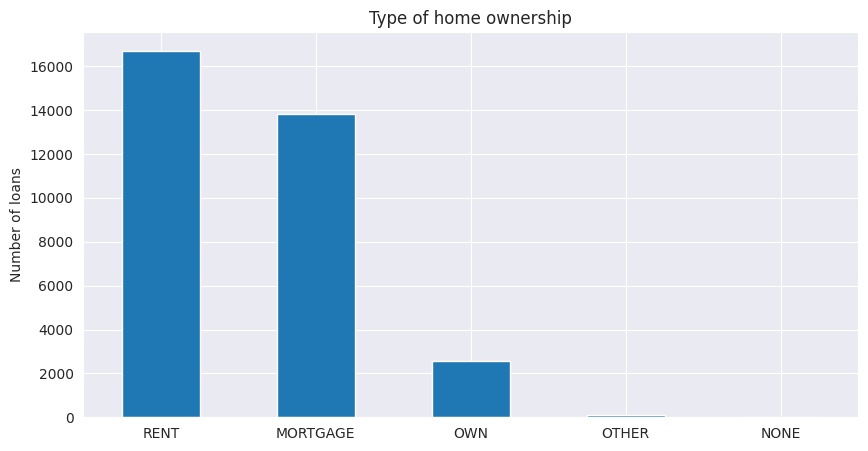

In [51]:
plt.figure(figsize=(10, 5))
data_df.home_ownership.value_counts().plot.bar()
plt.title("Type of home ownership")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- **~16800** applicants are renters, closely followed by applicates with mortgage

### Verification Status of Income

In [52]:
data_df.verification_status.value_counts()

verification_status
Not Verified       15532
Verified            9272
Source Verified     8428
Name: count, dtype: int64

We observe that:
- ~**15500** applicants' income is not verified
- Only ~**25%** of the applicants' source of income is verified

### Purpose of Loan

In [55]:
data_df.purpose.str.upper().value_counts()

purpose
DEBT_CONSOLIDATION    15183
CREDIT_CARD            4334
OTHER                  3520
HOME_IMPROVEMENT       2324
MAJOR_PURCHASE         1945
SMALL_BUSINESS         1497
CAR                    1409
WEDDING                 833
MEDICAL                 610
MOVING                  537
VACATION                360
EDUCATIONAL             304
HOUSE                   289
RENEWABLE_ENERGY         87
Name: count, dtype: int64

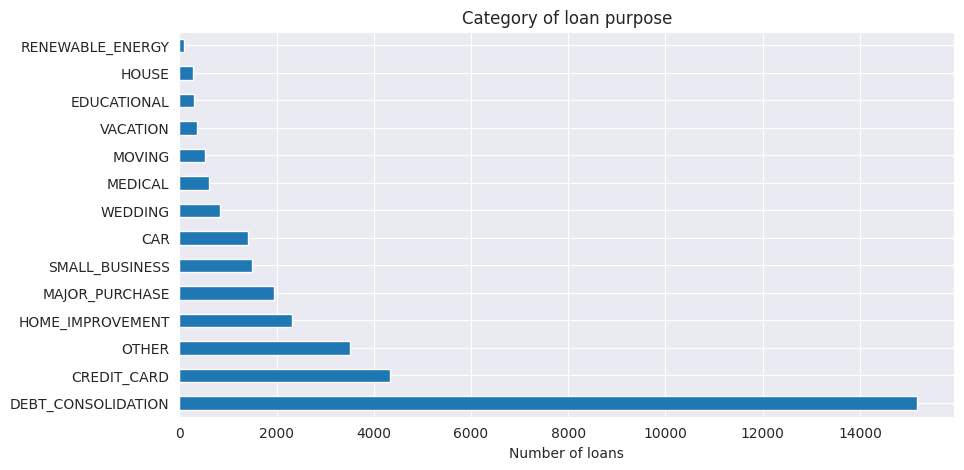

In [56]:
plt.figure(figsize=(10, 5))
data_df.purpose.str.upper().value_counts().plot.barh()
plt.title("Category of loan purpose")
plt.ylabel("")
plt.xlabel("Number of loans")
plt.show()

We observe that:
- Most popular reason for applying for a loan is **debt consilidation (~45%)**
- Least number of loan application are for **Renewable Energy**, **Education**, and **Housing** 

### Title

In [57]:
data_df.title.value_counts()[:10]

title
debt consolidation           2465
debt consolidation loan      1407
personal loan                 866
consolidation                 573
personal                      491
home improvement              433
credit card consolidation     414
credit card loan              298
small business loan           285
consolidation loan            276
Name: count, dtype: int64

We observe that:
- Most loans are applied for **Debt Consolidation**

### State of residence 

In [58]:
data_df.addr_state.value_counts()

addr_state
CA    6001
NY    3143
FL    2447
TX    2235
NJ    1518
PA    1284
IL    1280
GA    1171
VA    1157
MA    1108
OH    1049
MD     874
AZ     731
WA     723
CO     666
NC     633
MI     606
CT     602
MO     584
MN     540
NV     413
SC     401
OR     386
AL     386
WI     375
LA     365
KY     270
OK     251
KS     215
UT     207
AR     205
RI     172
DC     167
NM     165
WV     148
NH     145
HI     143
DE      98
WY      72
MT      68
AK      62
SD      55
VT      51
MS      19
TN      16
IN       7
IA       5
NE       5
ID       5
ME       3
Name: count, dtype: int64

We observe that:
- Most applicants are from the California, New York and Florida
- Idaho, Nebraska, and Maine are the states with least number of loan applications

### Debt-To-Income Ratio

In [60]:
data_df.dti.describe()

count    33232.000000
mean        13.358439
std          6.675129
min          0.000000
25%          8.210000
50%         13.470000
75%         18.650000
max         29.990000
Name: dti, dtype: float64

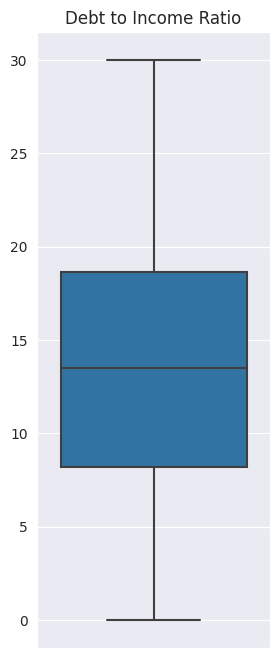

In [61]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.dti)
plt.title('Debt to Income Ratio')
plt.xticks(ticks=[])
plt.show()

We observe that:
- The median ratio is 13.3, which is a quite good
- 25% of the applicants have DTI > 18.7

### Deliquincy in the past 2 years

In [62]:
data_df.delinq_2yrs.value_counts()

delinq_2yrs
0     29614
1      2779
2       567
3       183
4        53
5        18
6        10
7         4
8         2
9         1
11        1
Name: count, dtype: int64

We observe that:
- Most of the applicants have not shown any delinquent behviour in the past 2 years
- Less than 100 applicant have a record of 4 or more delinquency incidence in past 2 year

### Inquiries made in the past 6 months

In [63]:
data_df.inq_last_6mths.value_counts()

inq_last_6mths
0    16257
1     9214
2     4789
3     2524
4      256
5      110
6       44
7       27
8       11
Name: count, dtype: int64

### Earliest Credit Line Year

The year the borrower's earliest reported credit line was opened

In [64]:
data_df.earliest_cr_line_year.value_counts()

earliest_cr_line_year
2000    2775
1999    2518
1998    2392
2001    2166
1997    2040
1996    1840
1995    1718
2002    1695
2003    1684
2004    1600
1994    1583
2005    1378
1993    1191
2006    1104
1992     845
1990     791
1991     759
1989     680
2007     676
1988     588
1987     479
1986     408
1985     358
1984     309
1983     252
1982     173
2008     147
1980     147
1981     137
1978     134
1979     122
1977      85
1976      74
1975      68
1974      53
1973      47
1970      43
1972      38
1971      36
1969      30
1967      16
1968      15
1963      10
1966       9
1964       5
1965       4
1962       3
1954       2
1961       2
1959       1
1956       1
1946       1
Name: count, dtype: int64

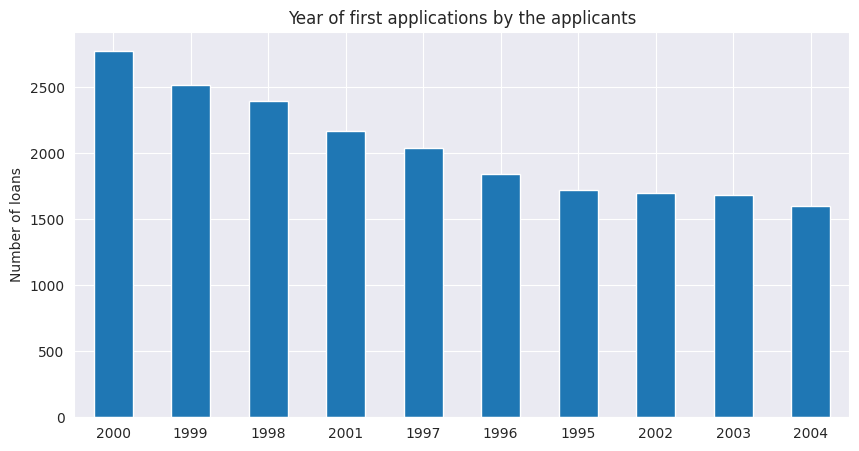

In [65]:
plt.figure(figsize=(10, 5))
data_df.earliest_cr_line_year.value_counts()[:10].plot.bar()
plt.title('Year of first applications by the applicants')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Although the earliest line of credit for the applicants can be traced back to 1946, most of the applicant have thier first line of credit in the 1990s and 2000s

### Earliest Credit Line Month 

The month the borrower's earliest reported credit line was opened


In [66]:
data_df.earliest_cr_line_month.value_counts()

earliest_cr_line_month
Oct    3442
Dec    3395
Nov    3310
Sep    3048
Jan    2870
Aug    2786
Jul    2555
Jun    2440
May    2416
Feb    2382
Mar    2338
Apr    2250
Name: count, dtype: int64

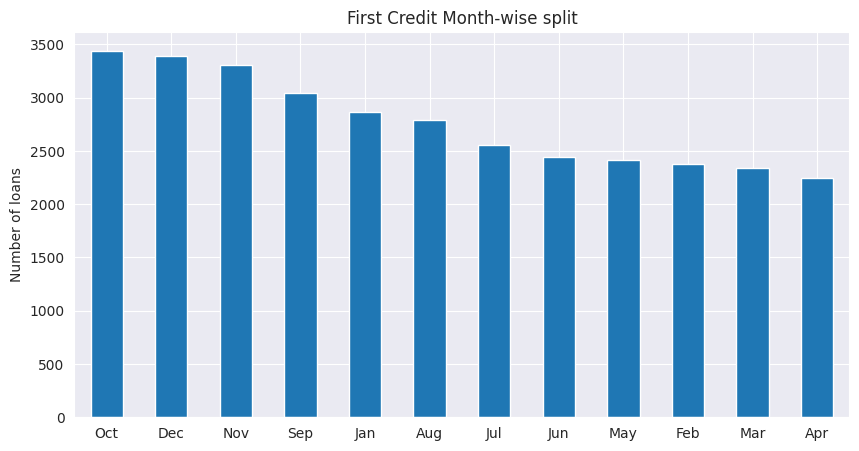

In [67]:
plt.figure(figsize=(10, 5))
data_df.earliest_cr_line_month.value_counts().plot.bar()
plt.title('First Credit Month-wise split')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most applicants took their first loans in the month of October, followed by December and November

### Issued Year and month 

The month and the year in which loan was funded

In [68]:
data_df.issue_d_year.value_counts()

issue_d_year
2011    17054
2010    10236
2009     4263
2008     1457
2007      222
Name: count, dtype: int64

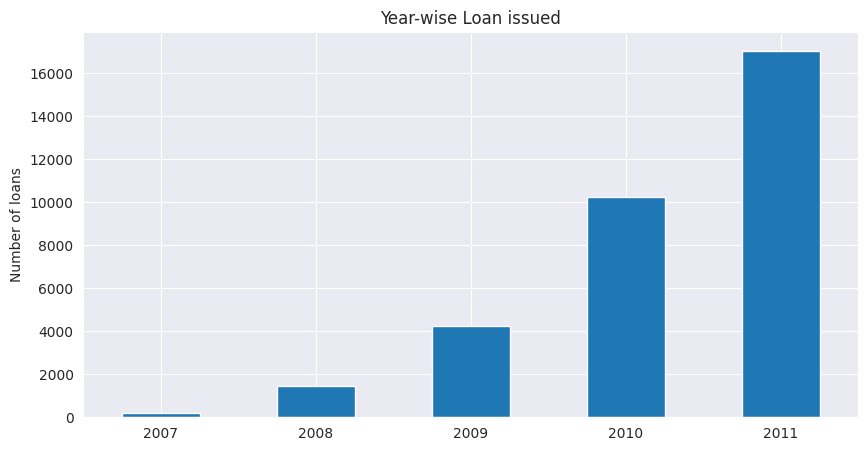

In [69]:
plt.figure(figsize=(10, 5))
data_df.issue_d_year.value_counts().sort_index().plot.bar()
plt.title('Year-wise Loan issued')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most loans are issue in 2011
- There is a steady increase in the number of loans issues YoY

In [70]:
data_df.issue_d_month.value_counts()

issue_d_month
Dec    3573
Nov    3417
Oct    3166
Sep    2950
Jul    2916
Aug    2878
Jun    2746
May    2562
Apr    2482
Mar    2361
Feb    2093
Jan    2088
Name: count, dtype: int64

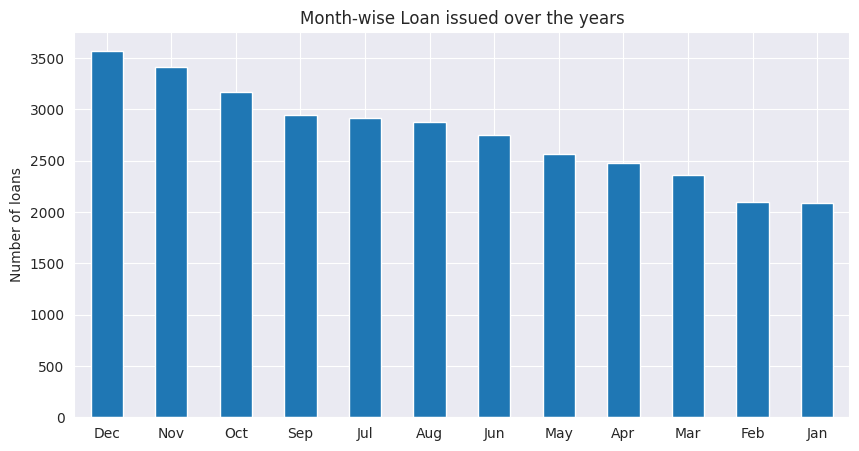

In [71]:
plt.figure(figsize=(10, 5))
data_df.issue_d_month.value_counts().plot.bar()
plt.title('Month-wise Loan issued over the years')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Top-2 months are December and November with more than 4000 application every month
- January and February have the lowest number of applications

### Public Record Bankruptcies

Number of public record bankruptcies

In [72]:
data_df.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.0    31113
1.0     1477
2.0        5
Name: count, dtype: int64

We observe that:
- There are 1513 borrowers who have declared bankruptcy among which only 6 have declared bankrupcies twice

### Last Credit Pulled date

The most recent month LC pulled the credit for this loan

In [73]:
data_df.last_credit_pull_d_year.value_counts()

last_credit_pull_d_year
2016    12405
2014     5524
2015     4781
2013     4474
2012     3394
2011     1768
2010      662
2009      177
2008       26
2007       19
Name: count, dtype: int64

In [74]:
data_df.last_credit_pull_d_month.value_counts()

last_credit_pull_d_month
May    9791
Apr    3652
Mar    2810
Feb    2606
Dec    2096
Nov    1940
Sep    1805
Oct    1775
Jan    1766
Aug    1752
Jul    1729
Jun    1508
Name: count, dtype: int64

### Last Payment Year and Month

In [75]:
data_df.last_pymnt_d_year.value_counts()

last_pymnt_d_year
2014    8413
2013    8255
2012    7405
2011    4021
2015    2181
2010    1474
2016     855
2009     452
2008     105
Name: count, dtype: int64

In [76]:
data_df.last_pymnt_d_month.value_counts()

last_pymnt_d_month
Mar    3207
Dec    3074
Oct    2837
Aug    2799
Jul    2780
Feb    2751
May    2749
Apr    2658
Jan    2629
Sep    2583
Nov    2573
Jun    2521
Name: count, dtype: int64

### Collection Recovery Fee

In [77]:
data_df.collection_recovery_fee.describe()

count    33232.000000
mean        13.733447
std        154.926539
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7002.190000
Name: collection_recovery_fee, dtype: float64

> **NOTE**: Since the collection recovery fee is only applicable in case of bad loan, we are choosing not to remove outliers from this column.  

We observe that:
- Collection recovery fee is 0 for most of the application

### Recoveries

In [79]:
data_df.recoveries.describe()

count    33232.000000
mean       107.615220
std        731.187385
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      29623.350000
Name: recoveries, dtype: float64

> **NOTE**: Since the recoveries is only applicable in case of bad loan, we are choosing not to remove outliers from this column.  

We observe that:
- Recoveries is 0 for most of the application

### Total Recovered Late Fee

In [81]:
data_df.total_rec_late_fee.describe()

count    33232.000000
mean         1.443997
std          7.473277
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64

Here also we can that the column doesn't have any significant data

### Total Recovery Interest

In [82]:
data_df.total_rec_int.describe()

count    33232.000000
mean      1879.909254
std       2056.450259
min          0.000000
25%        611.017500
50%       1200.135000
75%       2357.072500
max      23563.680000
Name: total_rec_int, dtype: float64

### Total Recovery Principle 

In [83]:
data_df.total_rec_prncp.describe()

count    33232.000000
mean      8281.319242
std       5857.831213
min          0.000000
25%       4000.000000
50%       7000.000000
75%      11222.957500
max      35000.000000
Name: total_rec_prncp, dtype: float64

### Total Payment Funded by Investors

Total payment received for the amount invested by the investors

In [85]:
data_df.total_pymnt_inv.describe()

count    33232.000000
mean      9735.880860
std       7326.188882
min          0.000000
25%       4510.477500
50%       7908.745000
75%      13146.637500
max      58563.680000
Name: total_pymnt_inv, dtype: float64

### Total Payment 

In [86]:
data_df.total_pymnt.describe()

count    33232.000000
mean     10270.287629
std       7430.283617
min          0.000000
25%       5001.638690
50%       8436.838817
75%      13695.970025
max      58563.679930
Name: total_pymnt, dtype: float64

From this we can understand that the median amount of the total payment received is 9899 USD

### Out Principal and Out Principal Invested by Investors

Remaining outstanding principal for total amount funded and Remaining outstanding principal for total amount funded by investors

In [89]:
data_df.out_prncp_inv.describe()

count    33232.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: out_prncp_inv, dtype: float64

In [90]:
data_df.out_prncp.describe()

count    33232.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: out_prncp, dtype: float64

Since these two do not have any value other than $0$, we are choosing to drop them.

In [91]:
data_df = data_df.drop(['out_prncp', 'out_prncp_inv'], axis=1)

### Total Accounts

The total number of credit lines currently in the borrower's credit file


In [92]:
data_df.total_acc.describe()

count    33232.000000
mean        21.204983
std         11.124622
min          2.000000
25%         13.000000
50%         20.000000
75%         28.000000
max         90.000000
Name: total_acc, dtype: float64

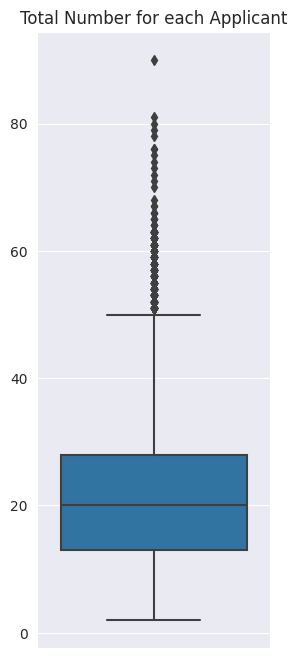

In [93]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_acc)
plt.title('Total Number for each Applicant')
plt.xticks(ticks=[])
plt.show()

### Revolving Credit Utilization 

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [94]:
data_df.revol_util.describe()

count    33183.000000
mean        48.661622
std         28.371270
min          0.000000
25%         25.100000
50%         49.000000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

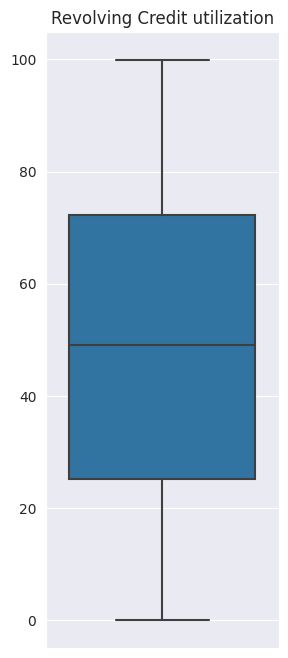

In [95]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.revol_util)
plt.title('Revolving Credit utilization')
plt.xticks(ticks=[])
plt.show()

### Revolving balance

In [96]:
data_df.revol_bal.describe()

count     33232.000000
mean      11941.561958
std       13716.997300
min           0.000000
25%        3382.000000
50%        8081.000000
75%       15489.000000
max      149000.000000
Name: revol_bal, dtype: float64

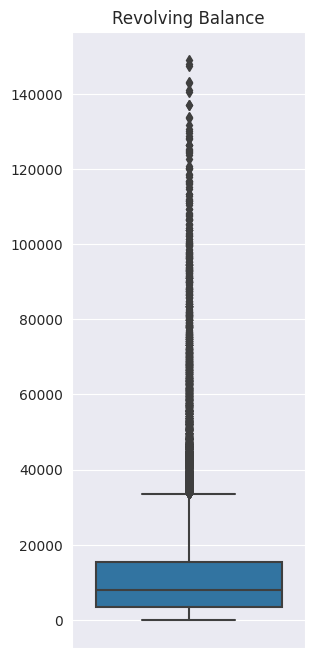

In [97]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.revol_bal)
plt.title('Revolving Balance')
plt.xticks(ticks=[])
plt.show()

We observe that:
- The median of the total revolving balance is **~USD 8000**

### Public Records

The number of derogatory public records

In [98]:
data_df.pub_rec.value_counts()

pub_rec
0    31356
1     1823
2       45
3        6
4        2
Name: count, dtype: int64

These number show that majoriity of the borrowers don't have derogaotry public records

### Open Credit lines

The number of open credit lines in the borrower's credit file.

In [100]:
data_df.open_acc.value_counts()

open_acc
6     3427
7     3415
8     3306
9     3105
5     2816
10    2612
11    2232
4     2099
12    1821
13    1533
3     1373
14    1174
15     936
16     717
2      568
17     565
18     417
19     300
20     223
21     196
22     114
23      70
24      61
25      47
26      26
28      21
27      17
29       9
30       8
31       6
34       4
35       3
32       2
33       2
36       2
39       1
38       1
44       1
41       1
42       1
Name: count, dtype: int64

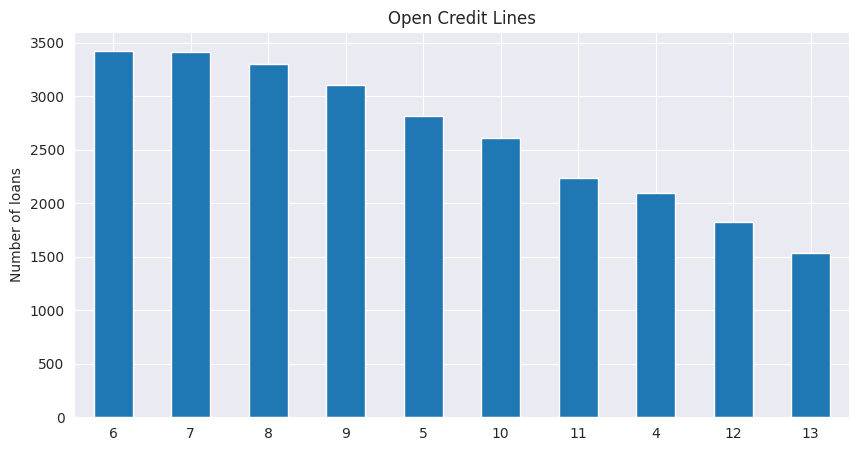

In [101]:
plt.figure(figsize=(10, 5))
data_df.open_acc.value_counts()[:10].plot.bar()
plt.title('Open Credit Lines')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- **~7000** applicants have 6 or 7 lines of credit
- **~600** applicants have more than 20 credit lines

## Step 3: Segmented Uni-Variate Analysis

### Segmenting based on Loan Status

#### Loan Amount, Funded Amount, Investor Amounts

**Mean**

In [22]:
temp_df = data_df.groupby(['loan_status']).agg({'loan_amnt': 'mean', 'funded_amnt':'mean', 'funded_amnt_inv':'mean'}).reset_index()
temp_df.columns = ['loan_status', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,loan_status,loan_amount,funded_amount,funded_amount_inv
0,Charged Off,11846.081577,11520.242896,10653.391105
1,Fully Paid,9340.482234,9146.429600,8697.482045


In [23]:
temp_df = temp_df.melt(id_vars='loan_status', var_name='agg_fn', value_name='agg_value')
temp_df

,loan_status,agg_fn,agg_value
0,Charged Off,loan_amount,11846.081577
1,Fully Paid,loan_amount,9340.482234
2,Charged Off,funded_amount,11520.242896
3,Fully Paid,funded_amount,9146.429600
4,Charged Off,funded_amount_inv,10653.391105
5,Fully Paid,funded_amount_inv,8697.482045


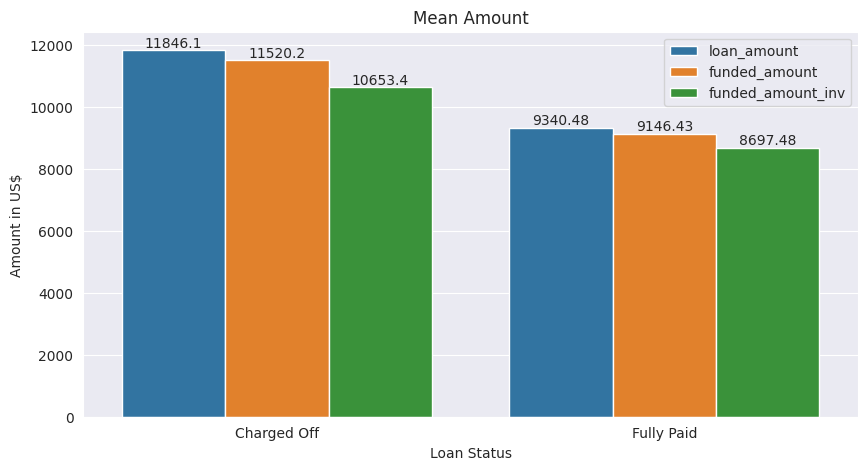

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=temp_df, x='loan_status', y='agg_value', hue='agg_fn')
ax.bar_label(ax.containers[0])# fmt="{:0f}")
ax.bar_label(ax.containers[1])# fmt="{:0.1f}")
ax.bar_label(ax.containers[2])# fmt="{:0.1f}")
plt.title("Mean Amount")
plt.xlabel("Loan Status")
plt.ylabel("Amount in US$")
plt.legend()
plt.show()

**Median**

In [25]:
temp_df = data_df.groupby(['loan_status']).agg({'loan_amnt': 'median',
                                                'funded_amnt':'median',
                                                'funded_amnt_inv':'median'}).reset_index()
temp_df.columns = ['loan_status', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,loan_status,loan_amount,funded_amount,funded_amount_inv
0,Charged Off,10000.0,10000.0,9000.0
1,Fully Paid,8000.0,8000.0,7500.0


In [26]:
temp_df = temp_df.melt(id_vars='loan_status', var_name='agg_fn', value_name='agg_value')
temp_df

,loan_status,agg_fn,agg_value
0,Charged Off,loan_amount,10000.0
1,Fully Paid,loan_amount,8000.0
2,Charged Off,funded_amount,10000.0
3,Fully Paid,funded_amount,8000.0
4,Charged Off,funded_amount_inv,9000.0
5,Fully Paid,funded_amount_inv,7500.0


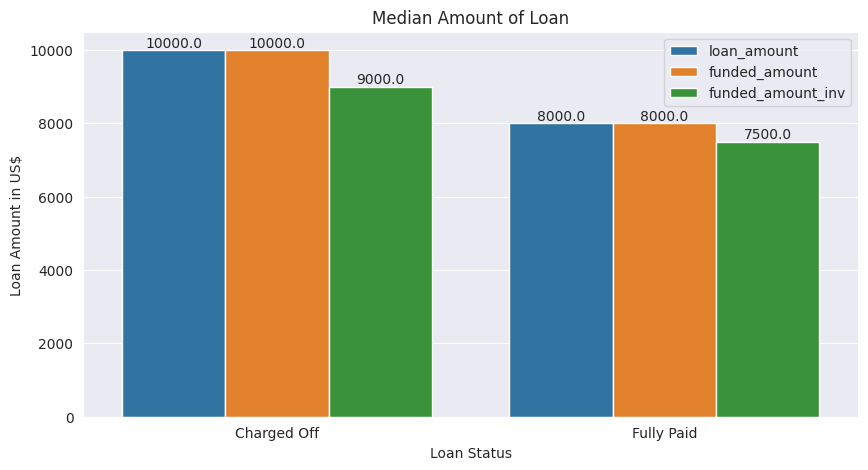

In [27]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=temp_df, x='loan_status', y='agg_value', hue='agg_fn')
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
ax.bar_label(ax.containers[1], fmt="{:0.1f}")
ax.bar_label(ax.containers[2], fmt="{:0.1f}")
plt.title("Median Amount of Loan")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount in US$")
plt.legend()
plt.show()
del temp_df

#### Interest Rate

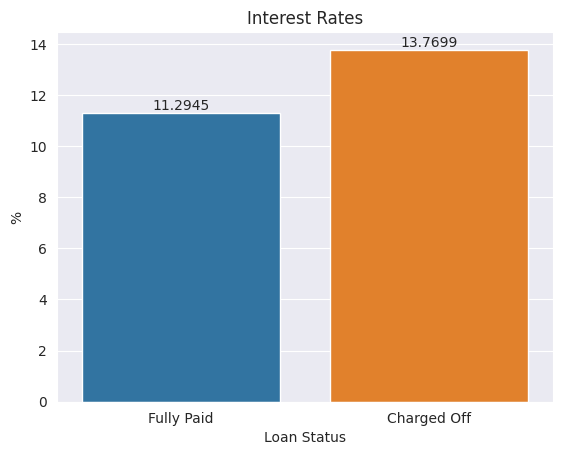

In [28]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='int_rate', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("%")
plt.show()

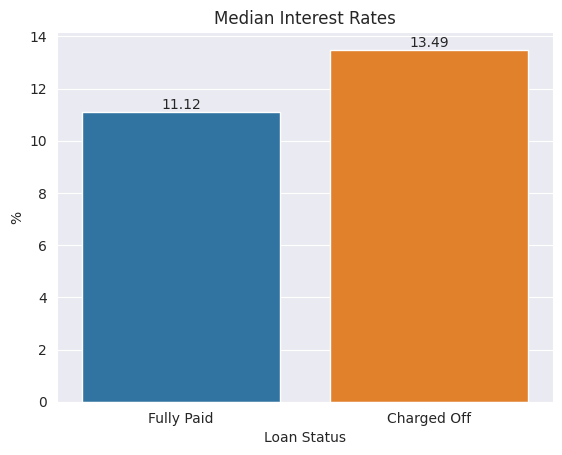

In [29]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='int_rate', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Median Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("%")
plt.show()

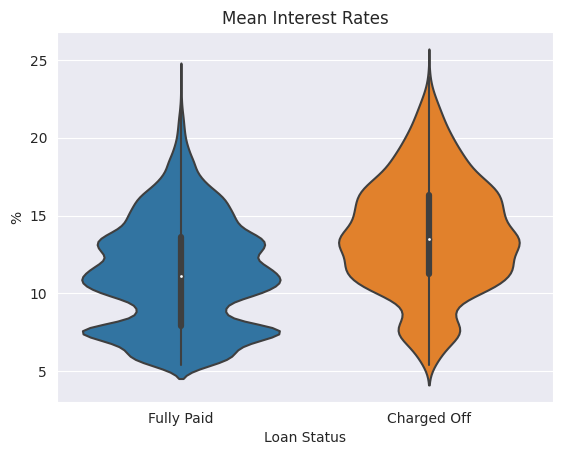

In [30]:
plt.figure()
sns.violinplot(data=data_df, x='loan_status', y='int_rate')
plt.title("Mean Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("%")
plt.show()

#### Installment

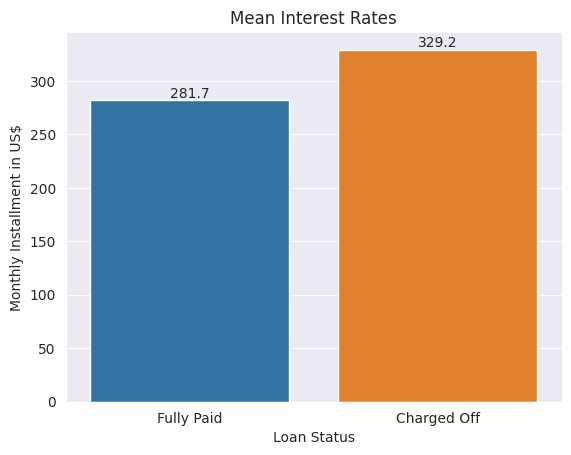

In [31]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='installment', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
plt.title("Mean Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("Monthly Installment in US$")
plt.show()

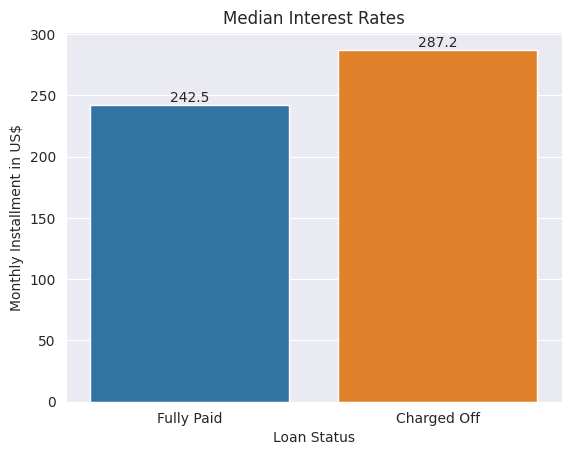

In [32]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='installment', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
plt.title("Median Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("Monthly Installment in US$")
plt.show()

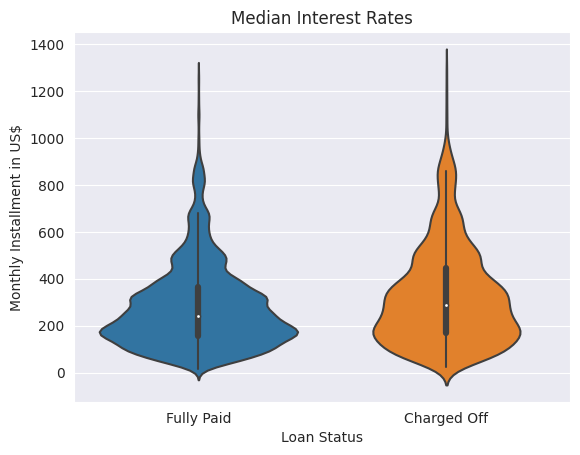

In [33]:
plt.figure()
ax = sns.violinplot(data=data_df, x='loan_status', y='installment')
plt.title("Median Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("Monthly Installment in US$")
plt.show()

#### Grade

In [34]:
a = data_df.groupby(['loan_status', 'grade'])['id'].count().reset_index()
aa = a.groupby(['grade'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='grade').drop_duplicates()
del aa
a.columns = ['loan_status', 'grade', 'num_appln', 'total_grade']
a['percent_grade'] = a.num_appln * 100 / a.total_grade
a

,loan_status,grade,num_appln,total_grade,percent_grade
0,Charged Off,A,597,9229,6.468740
1,Fully Paid,A,8632,9229,93.531260
2,Charged Off,B,1382,10057,13.741672
3,Fully Paid,B,8675,10057,86.258328
4,Charged Off,C,1328,6772,19.610159
5,Fully Paid,C,5444,6772,80.389841
6,Charged Off,D,1087,4308,25.232126
7,Fully Paid,D,3221,4308,74.767874
8,Charged Off,E,669,1985,33.702771
9,Fully Paid,E,1316,1985,66.297229


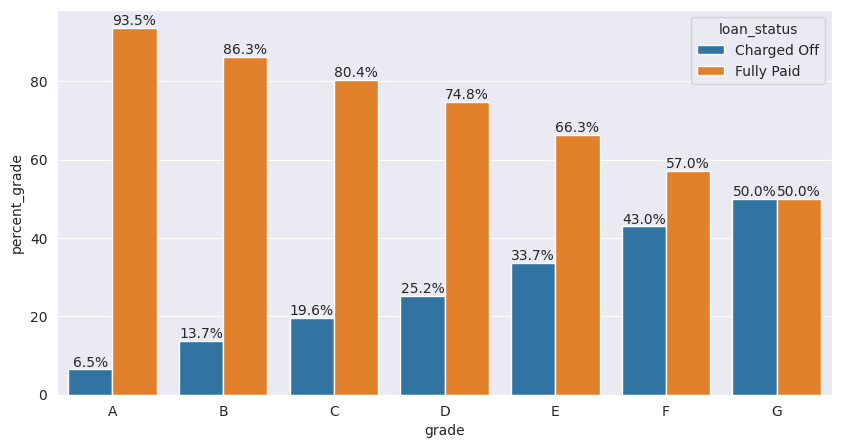

In [35]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=a, x='grade', y='percent_grade', hue='loan_status')
ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
plt.title('')
plt.show()

#### Debt-to-Income

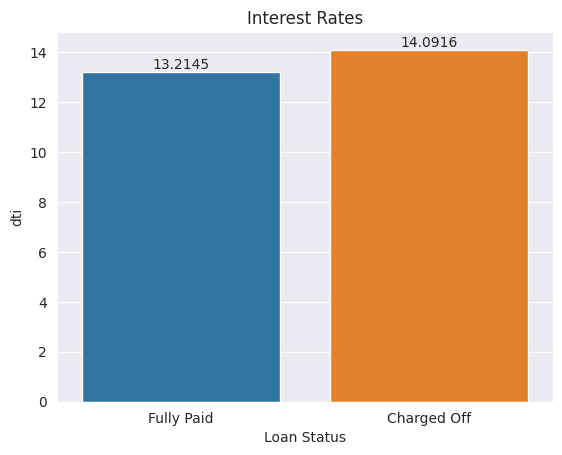

In [36]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='dti', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Loan Status")
# plt.ylabel("%")
plt.show()

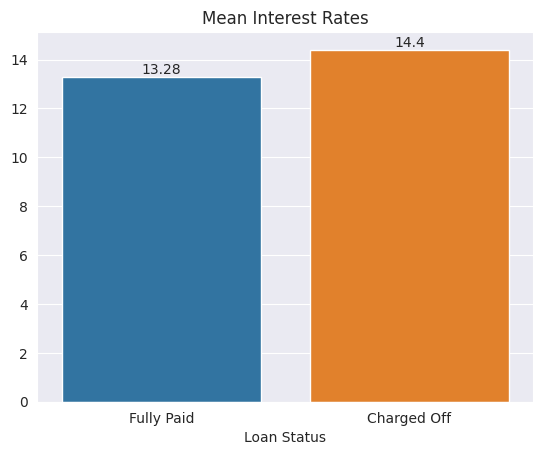

In [37]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='dti', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Mean Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("")
plt.show()

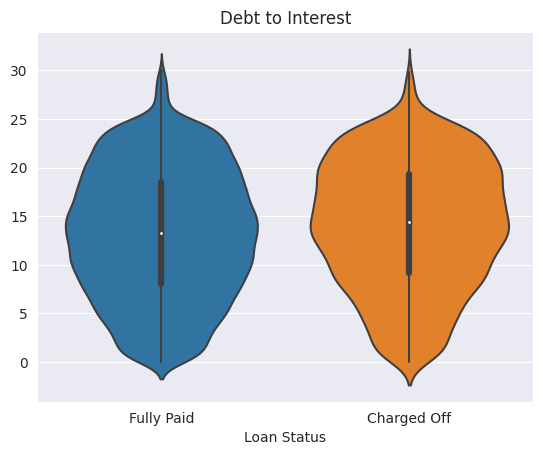

In [38]:
plt.figure()
sns.violinplot(data=data_df, x='loan_status', y='dti')
# ax.bar_label(ax.containers[0])
plt.title("Debt to Interest")
plt.xlabel("Loan Status")
plt.ylabel("")
plt.show()

#### Address State

In [39]:
a = data_df.groupby(['loan_status', 'addr_state'])['id'].count().reset_index()
aa = a.groupby(['addr_state'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='addr_state').drop_duplicates()
del aa
a.columns = ['loan_status', 'addr_state', 'num_appln', 'total_state']
a['percent_state'] = a.num_appln * 100 / a.total_state
a = a.sort_values(by='total_state', ascending=False)
a

,loan_status,addr_state,num_appln,total_state,percent_state
9,Fully Paid,CA,4917,6001,81.936344
8,Charged Off,CA,1084,6001,18.063656
61,Fully Paid,NY,2667,3143,84.855234
60,Charged Off,NY,476,3143,15.144766
18,Charged Off,FL,488,2447,19.942787
19,Fully Paid,FL,1959,2447,80.057213
78,Charged Off,TX,295,2235,13.199105
79,Fully Paid,TX,1940,2235,86.800895
54,Charged Off,NJ,271,1518,17.852437
55,Fully Paid,NJ,1247,1518,82.147563


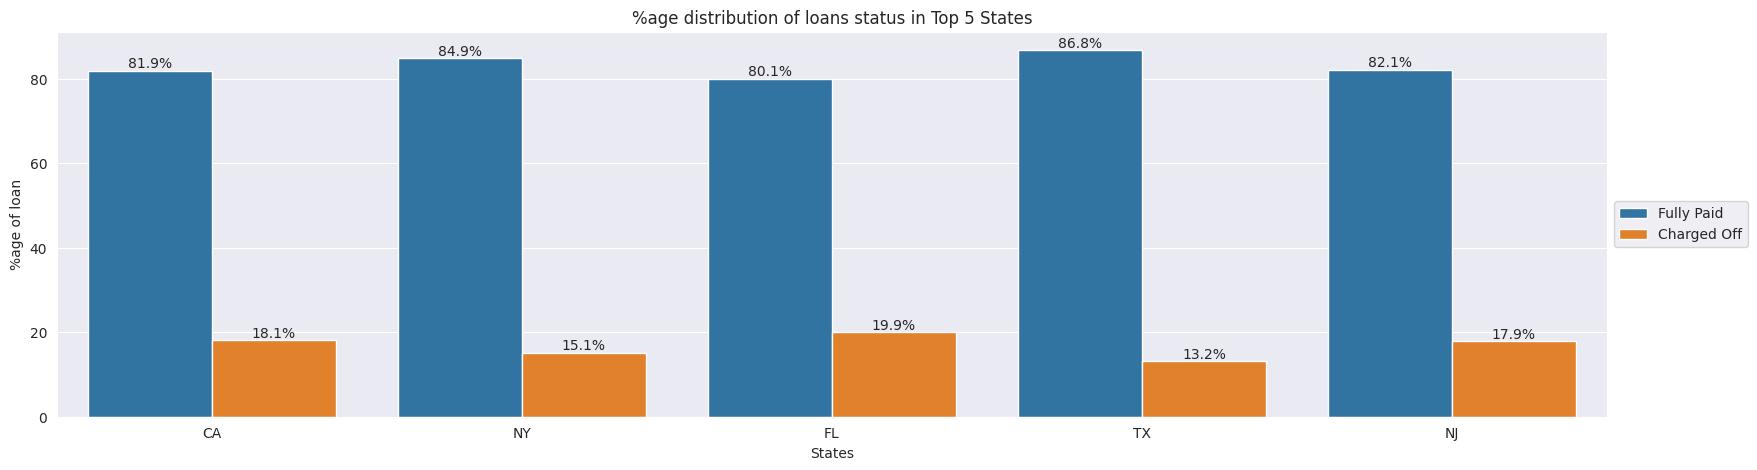

In [40]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(data=a.iloc[:10], x='addr_state', y='percent_state', hue='loan_status')
ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
plt.title('%age distribution of loans status in Top 5 States')
plt.xlabel('States')
plt.ylabel('%age of loan')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
del a

#### Open Accounts

<Axes: xlabel='open_acc', ylabel='loan_status'>

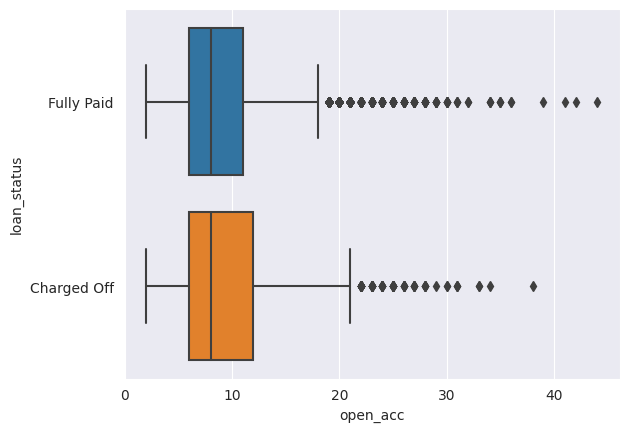

In [41]:
sns.boxplot(data=data_df, y='loan_status', x='open_acc')

#### Revolving Balance

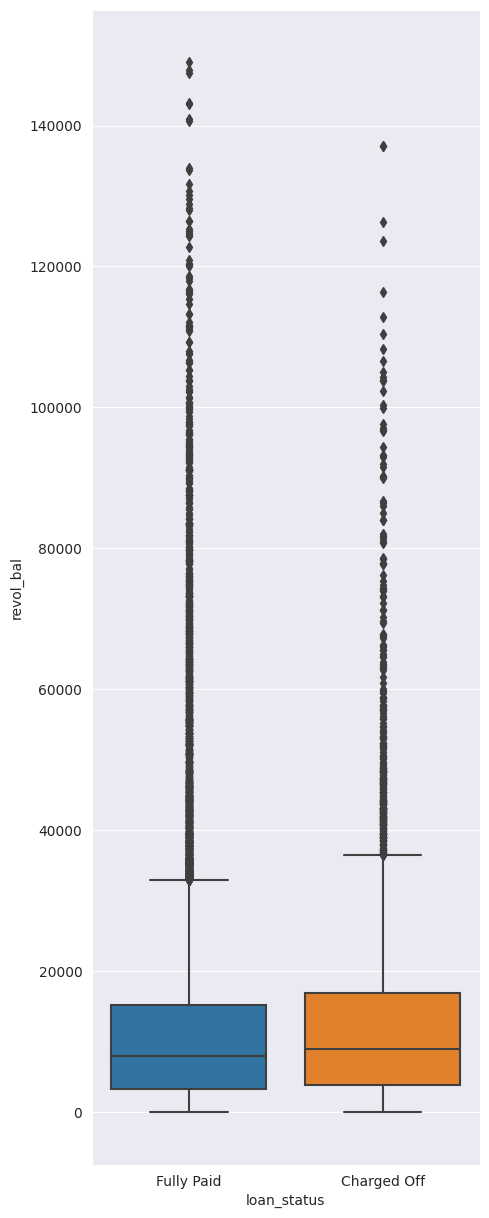

In [181]:
plt.figure(figsize=(5, 15))
sns.boxplot(data=data_df, x='loan_status', y='revol_bal')
plt.show()

#### Reloving Utilization

<Axes: xlabel='loan_status', ylabel='revol_util'>

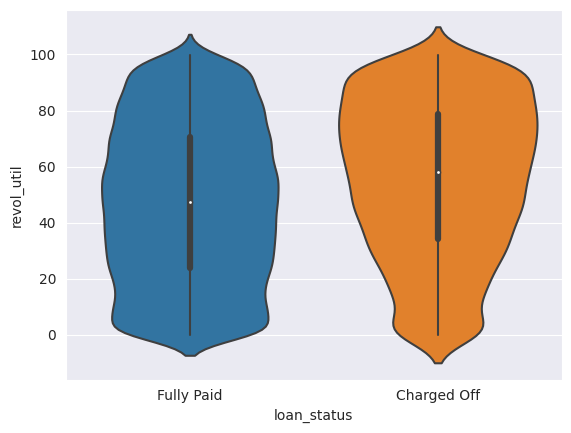

In [182]:
sns.violinplot(data=data_df, x='loan_status', y='revol_util')

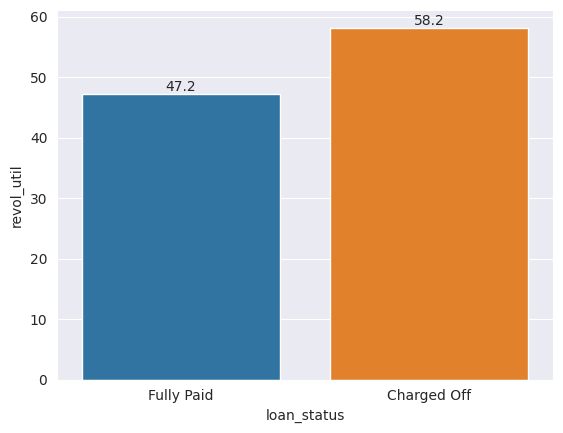

In [44]:
ax = sns.barplot(data=data_df, x='loan_status', y='revol_util', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.show()

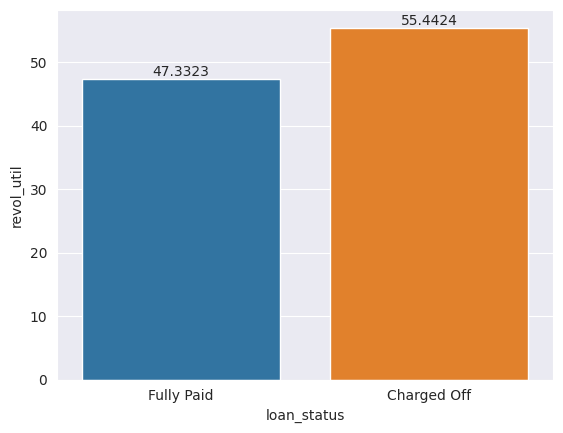

In [45]:
ax = sns.barplot(data=data_df, x='loan_status', y='revol_util', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.show()

#### Month of Issue

In [47]:
a = data_df.groupby(['loan_status', 'issue_d_month'])['id'].count().reset_index()
aa = a.groupby(['issue_d_month'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='issue_d_month').drop_duplicates()
del aa
a.columns = ['loan_status', 'issue_d_month', 'num_appln', 'total_per_month']
a['percent_month'] = a.num_appln * 100 / a.total_per_month
a = a.sort_values(by='total_per_month', ascending=False)
a

,loan_status,issue_d_month,num_appln,total_per_month,percent_month
4,Charged Off,Dec,659,3573,18.443885
5,Fully Paid,Dec,2914,3573,81.556115
19,Fully Paid,Nov,2833,3417,82.908984
18,Charged Off,Nov,584,3417,17.091016
21,Fully Paid,Oct,2612,3166,82.501579
20,Charged Off,Oct,554,3166,17.498421
23,Fully Paid,Sep,2414,2950,81.830508
22,Charged Off,Sep,536,2950,18.169492
10,Charged Off,Jul,463,2916,15.877915
11,Fully Paid,Jul,2453,2916,84.122085


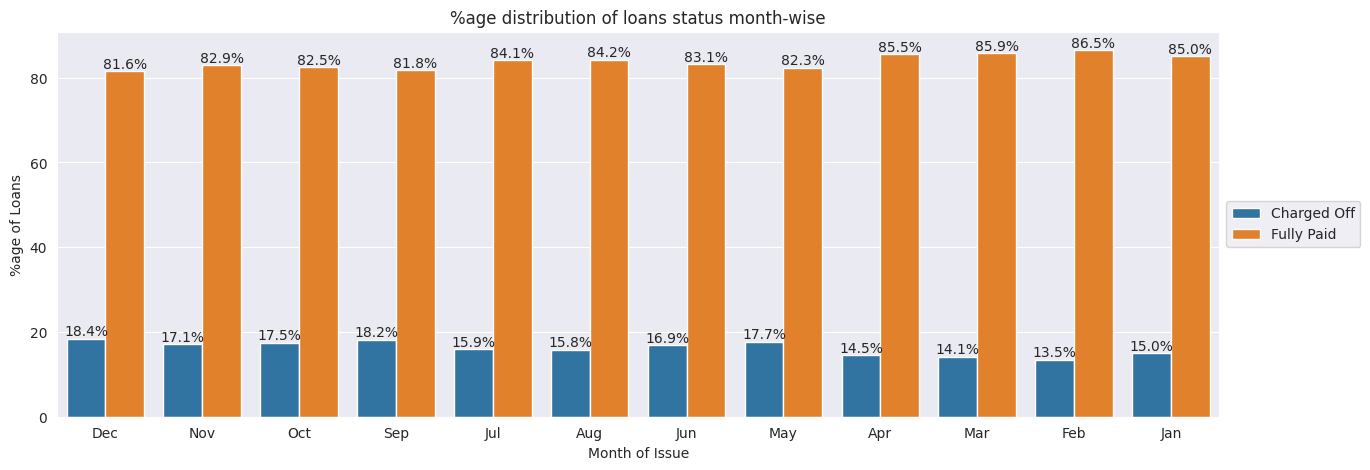

In [48]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=a, x='issue_d_month', y='percent_month', hue='loan_status')
ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
plt.title('%age distribution of loans status month-wise')
plt.xlabel('Month of Issue')
plt.ylabel('%age of Loans')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
del a

#### Year of Issue

In [49]:
a = data_df.groupby(['loan_status', 'issue_d_year'])['id'].count().reset_index()
aa = a.groupby(['issue_d_year'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='issue_d_year').drop_duplicates()
del aa
a.columns = ['loan_status', 'issue_d_year', 'num_appln', 'total_per_year']
a['percent_year'] = a.num_appln * 100 / a.total_per_year
a = a.sort_values(by='total_per_year', ascending=False)
a

,loan_status,issue_d_year,num_appln,total_per_year,percent_year
8,Charged Off,2011,3168,17054,18.576287
9,Fully Paid,2011,13886,17054,81.423713
6,Charged Off,2010,1433,10236,13.999609
7,Fully Paid,2010,8803,10236,86.000391
4,Charged Off,2009,572,4263,13.417781
5,Fully Paid,2009,3691,4263,86.582219
2,Charged Off,2008,240,1457,16.472203
3,Fully Paid,2008,1217,1457,83.527797
0,Charged Off,2007,42,222,18.918919
1,Fully Paid,2007,180,222,81.081081


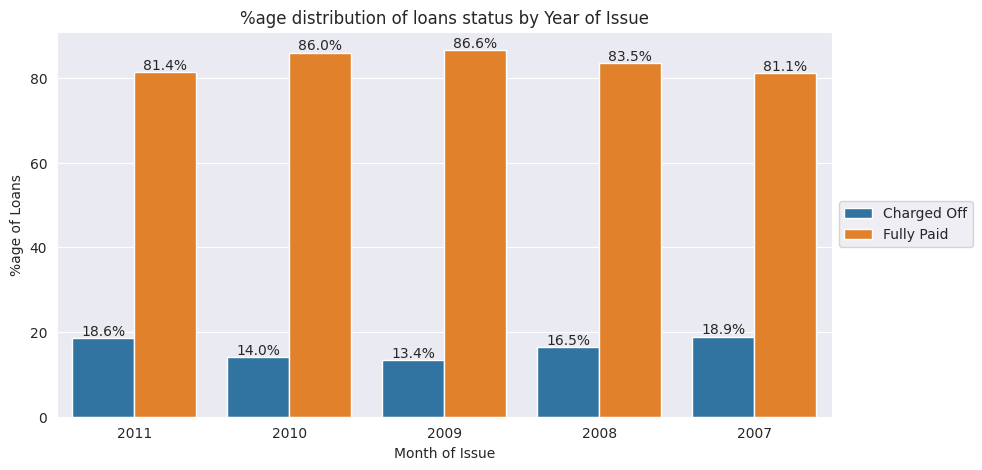

In [50]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=a, x='issue_d_year', y='percent_year', hue='loan_status')
ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
plt.title('%age distribution of loans status by Year of Issue')
plt.xlabel('Month of Issue')
plt.ylabel('%age of Loans')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
del a

#### Month of Earliest

In [52]:
a = data_df.groupby(['loan_status', 'earliest_cr_line_month'])['id'].count().reset_index()
aa = a.groupby(['earliest_cr_line_month'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='earliest_cr_line_month').drop_duplicates()
del aa
a.columns = ['loan_status', 'issue_d_month', 'num_appln', 'total_per_month']
a['percent_month'] = a.num_appln * 100 / a.total_per_month
a = a.sort_values(by=['total_per_month', 'loan_status'], ascending=[False, True])
a

,loan_status,issue_d_month,num_appln,total_per_month,percent_month
20,Charged Off,Oct,510,3442,14.816967
21,Fully Paid,Oct,2932,3442,85.183033
4,Charged Off,Dec,577,3395,16.995582
5,Fully Paid,Dec,2818,3395,83.004418
18,Charged Off,Nov,481,3310,14.531722
19,Fully Paid,Nov,2829,3310,85.468278
22,Charged Off,Sep,482,3048,15.813648
23,Fully Paid,Sep,2566,3048,84.186352
8,Charged Off,Jan,521,2870,18.153310
9,Fully Paid,Jan,2349,2870,81.846690


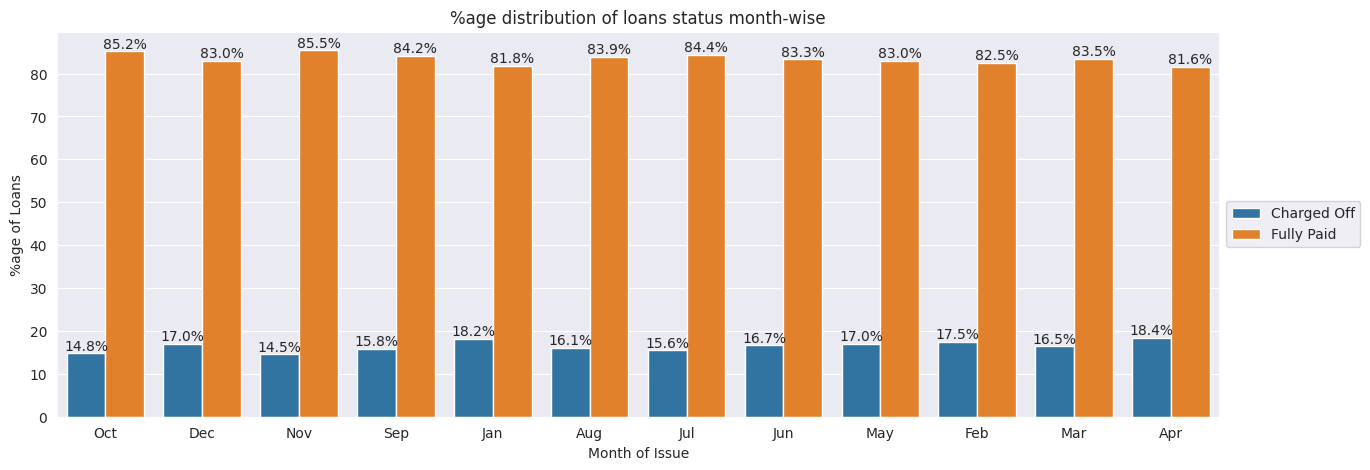

In [53]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=a, x='issue_d_month', y='percent_month', hue='loan_status')
ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
plt.title('%age distribution of loans status month-wise')
plt.xlabel('Month of Issue')
plt.ylabel('%age of Loans')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
del a

#### Year of Earliest Credit

In [122]:
a = data_df.groupby(['loan_status', 'earliest_cr_line_year'])['id'].count().reset_index()
aa = a.groupby(['earliest_cr_line_year'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='earliest_cr_line_year').drop_duplicates()
del aa
a.columns = ['loan_status', 'earliest_cr_line_year', 'num_appln', 'total_per_year']
a['percent_year'] = a.num_appln * 100 / a.total_per_year
a = a.sort_values(by=['earliest_cr_line_year', 'loan_status'], ascending=[True, True])
a = a[['loan_status', 'earliest_cr_line_year', 'percent_year']]

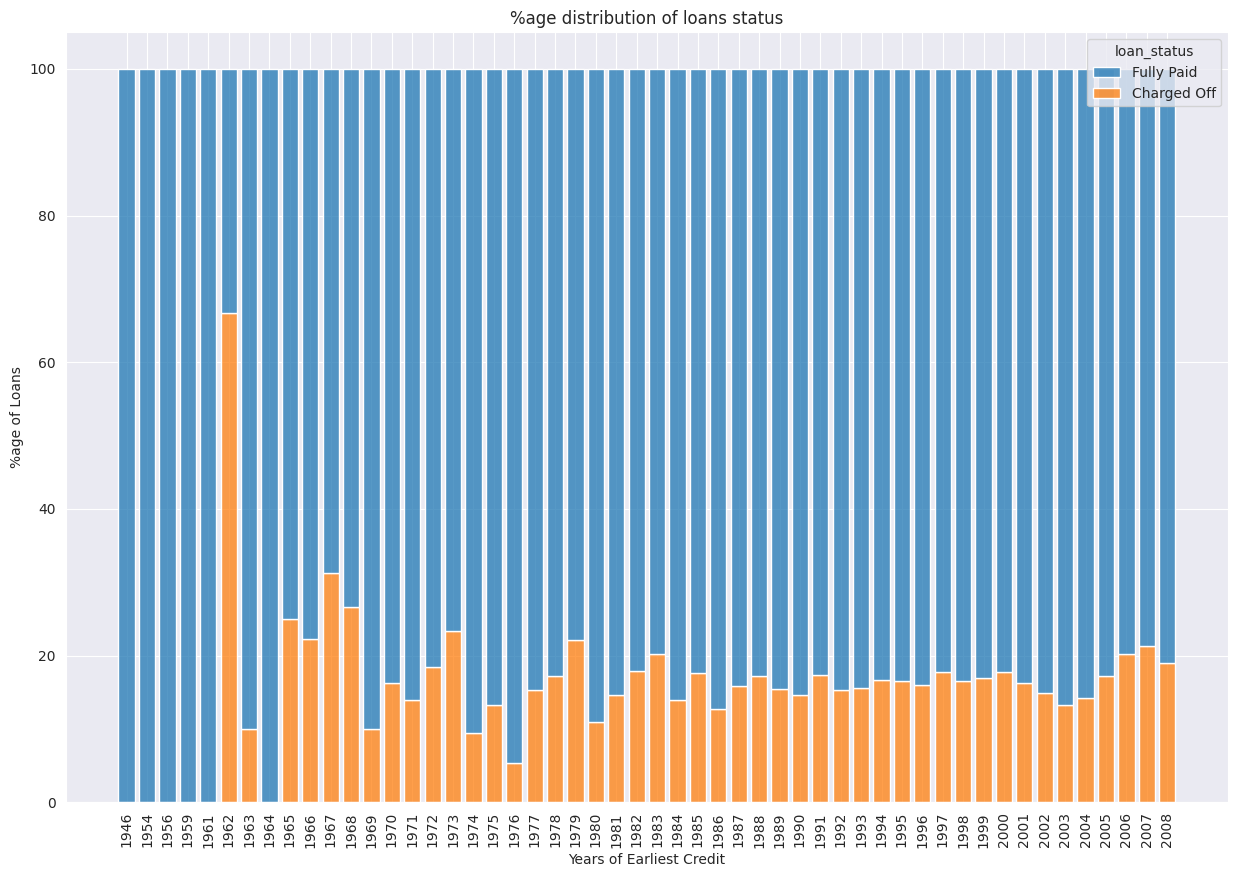

In [123]:
plt.figure(figsize=(15, 10))
sns.histplot(data=a, x='earliest_cr_line_year',
             weights='percent_year', hue='loan_status',
             multiple='stack', shrink=0.8)
# sns.lineplot(data=a, x='earliest_cr_line_year', y='percent_year', hue='loan_status')
plt.title('%age distribution of loans status')
plt.xlabel('Years of Earliest Credit')
plt.ylabel('%age of Loans')
plt.xticks(rotation=90)
plt.show()
del a

#### Purpose

In [69]:
a = data_df.groupby(['loan_status', 'purpose'])['id'].count().reset_index()
aa = a.groupby(['purpose'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='purpose').drop_duplicates()
del aa
a.columns = ['loan_status', 'purpose', 'num_appln', 'total_per_purpose']
a['percent_purpose'] = a.num_appln * 100 / a.total_per_purpose
a = a.sort_values(by=['total_per_purpose', 'loan_status'], ascending=[False, True])
a = a[['loan_status', 'purpose', 'percent_purpose']]

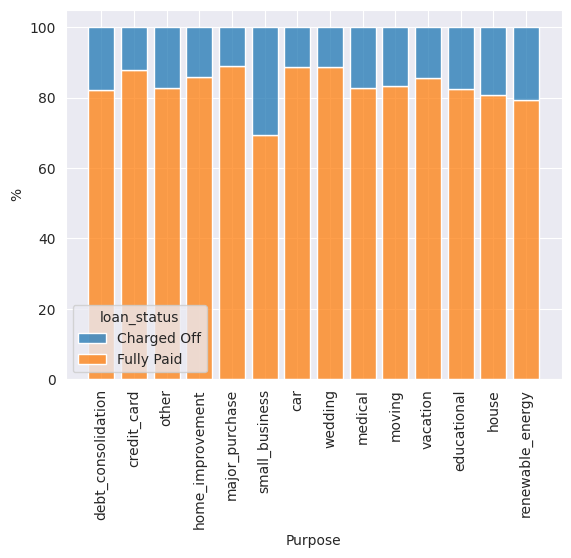

In [74]:
plt.figure()
sns.histplot(data=a, x='purpose', weights='percent_purpose', hue='loan_status', multiple='stack', shrink=0.8)
plt.xlabel("Purpose")
plt.ylabel('%')
plt.xticks(rotation=90)
plt.title("")
plt.show()

#### Terms

In [149]:
a = data_df.groupby(['loan_status', 'term'])['id'].count().reset_index()
aa = a.groupby(['term'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='term').drop_duplicates()
del aa
a.columns = ['loan_status', 'term', 'num_appln', 'total_per_term']
a['percent_term'] = a.num_appln * 100 / a.total_per_term
a = a.sort_values(by=['total_per_term', 'loan_status'], ascending=[False, True])
a = a[['loan_status', 'term', 'percent_term']]

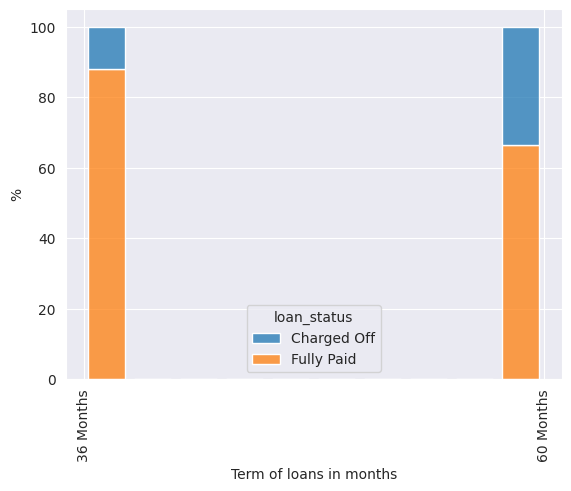

In [153]:
plt.figure()
sns.histplot(data=a, x='term', weights='percent_term', hue='loan_status', multiple='stack', shrink=0.8)
plt.xlabel("Term of loans in months")
plt.ylabel('%')
plt.xticks(ticks=[36, 60], labels=['36 Months', '60 Months'], rotation=90)
plt.title("")
plt.show()

#### Home Ownership

In [190]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33232 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        33232 non-null  int64  
 1   member_id                 33232 non-null  int64  
 2   loan_amnt                 33232 non-null  int64  
 3   funded_amnt               33232 non-null  int64  
 4   funded_amnt_inv           33232 non-null  float64
 5   term                      33232 non-null  int64  
 6   int_rate                  33232 non-null  float64
 7   installment               33232 non-null  float64
 8   grade                     33232 non-null  object 
 9   sub_grade                 33232 non-null  object 
 10  emp_title                 31147 non-null  object 
 11  emp_length                32282 non-null  object 
 12  home_ownership            33232 non-null  object 
 13  annual_inc                33232 non-null  float64
 14  verificatio

In [191]:
a = data_df.groupby(['loan_status', 'home_ownership'])['id'].count().reset_index()
aa = a.groupby(['home_ownership'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='home_ownership').drop_duplicates()
del aa
a.columns = ['loan_status', 'home_ownership', 'num_appln', 'total_per_term']
a['percent_term'] = a.num_appln * 100 / a.total_per_term
a = a.sort_values(by=['total_per_term', 'loan_status'], ascending=[False, True])
a = a[['loan_status', 'home_ownership', 'percent_term']]

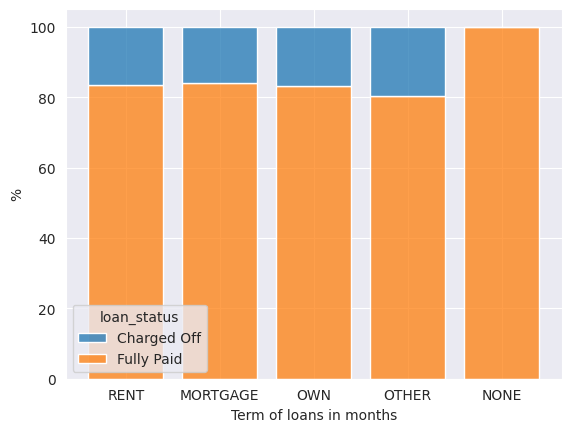

In [193]:
plt.figure()
sns.histplot(data=a, x='home_ownership', weights='percent_term', hue='loan_status', multiple='stack', shrink=0.8)
plt.xlabel("Term of loans in months")
plt.ylabel('%')
# plt.xticks(ticks=[36, 60], labels=['36 Months', '60 Months'], rotation=90)
plt.title("")
plt.show()

### Terms

#### Loan Amount

**Mean**

In [125]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33232 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        33232 non-null  int64  
 1   member_id                 33232 non-null  int64  
 2   loan_amnt                 33232 non-null  int64  
 3   funded_amnt               33232 non-null  int64  
 4   funded_amnt_inv           33232 non-null  float64
 5   term                      33232 non-null  int64  
 6   int_rate                  33232 non-null  float64
 7   installment               33232 non-null  float64
 8   grade                     33232 non-null  object 
 9   sub_grade                 33232 non-null  object 
 10  emp_title                 31147 non-null  object 
 11  emp_length                32282 non-null  object 
 12  home_ownership            33232 non-null  object 
 13  annual_inc                33232 non-null  float64
 14  verificatio

In [126]:
temp_df = data_df.groupby(['term']).agg({'loan_amnt': 'mean', 'funded_amnt':'mean', 'funded_amnt_inv':'mean'}).reset_index()
temp_df.columns = ['term', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,term,loan_amount,funded_amount,funded_amount_inv
0,36,8810.353353,8695.353923,8117.371825
1,60,13317.670365,12720.609422,12431.981644


In [127]:
temp_df = temp_df.melt(id_vars='term', var_name='agg_fn', value_name='agg_value')
temp_df

,term,agg_fn,agg_value
0,36,loan_amount,8810.353353
1,60,loan_amount,13317.670365
2,36,funded_amount,8695.353923
3,60,funded_amount,12720.609422
4,36,funded_amount_inv,8117.371825
5,60,funded_amount_inv,12431.981644


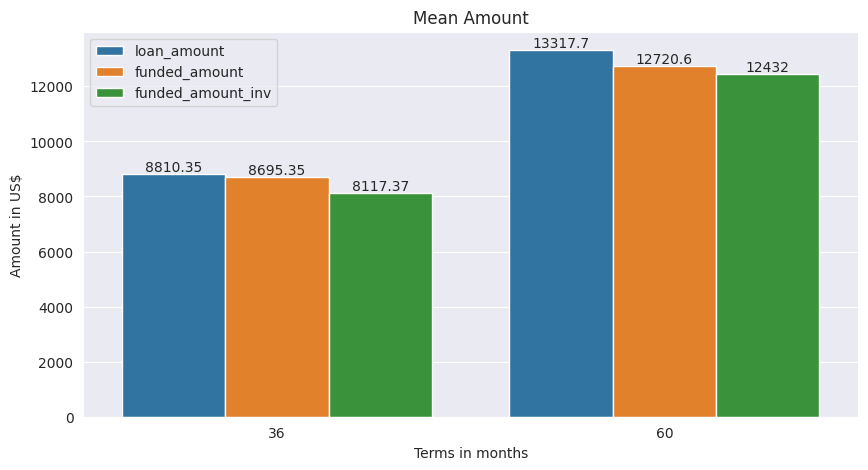

In [128]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=temp_df, x='term', y='agg_value', hue='agg_fn')
ax.bar_label(ax.containers[0])# fmt="{:0f}")
ax.bar_label(ax.containers[1])# fmt="{:0.1f}")
ax.bar_label(ax.containers[2])# fmt="{:0.1f}")
plt.title("Mean Amount")
plt.xlabel("Terms in months")
plt.ylabel("Amount in US$")
plt.legend()
plt.show()

**Median**

In [129]:
temp_df = data_df.groupby(['term']).agg({'loan_amnt': 'median',
                                                'funded_amnt':'median',
                                                'funded_amnt_inv':'median'}).reset_index()
temp_df.columns = ['term', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,term,loan_amount,funded_amount,funded_amount_inv
0,36,7500.0,7500.0,7000.0
1,60,12000.0,12000.0,11750.0


In [130]:
temp_df = temp_df.melt(id_vars='term', var_name='agg_fn', value_name='agg_value')
temp_df

,term,agg_fn,agg_value
0,36,loan_amount,7500.0
1,60,loan_amount,12000.0
2,36,funded_amount,7500.0
3,60,funded_amount,12000.0
4,36,funded_amount_inv,7000.0
5,60,funded_amount_inv,11750.0


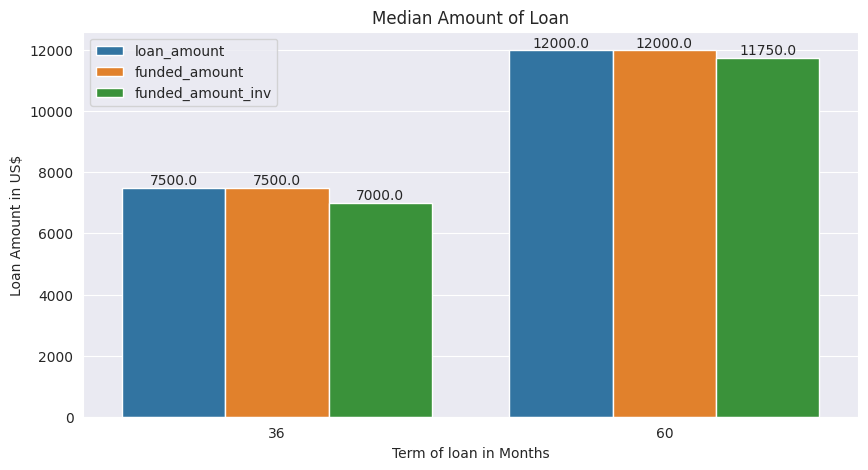

In [131]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=temp_df, x='term', y='agg_value', hue='agg_fn')
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
ax.bar_label(ax.containers[1], fmt="{:0.1f}")
ax.bar_label(ax.containers[2], fmt="{:0.1f}")
plt.title("Median Amount of Loan")
plt.xlabel("Term of loan in Months")
plt.ylabel("Loan Amount in US$")
plt.legend()
plt.show()
del temp_df

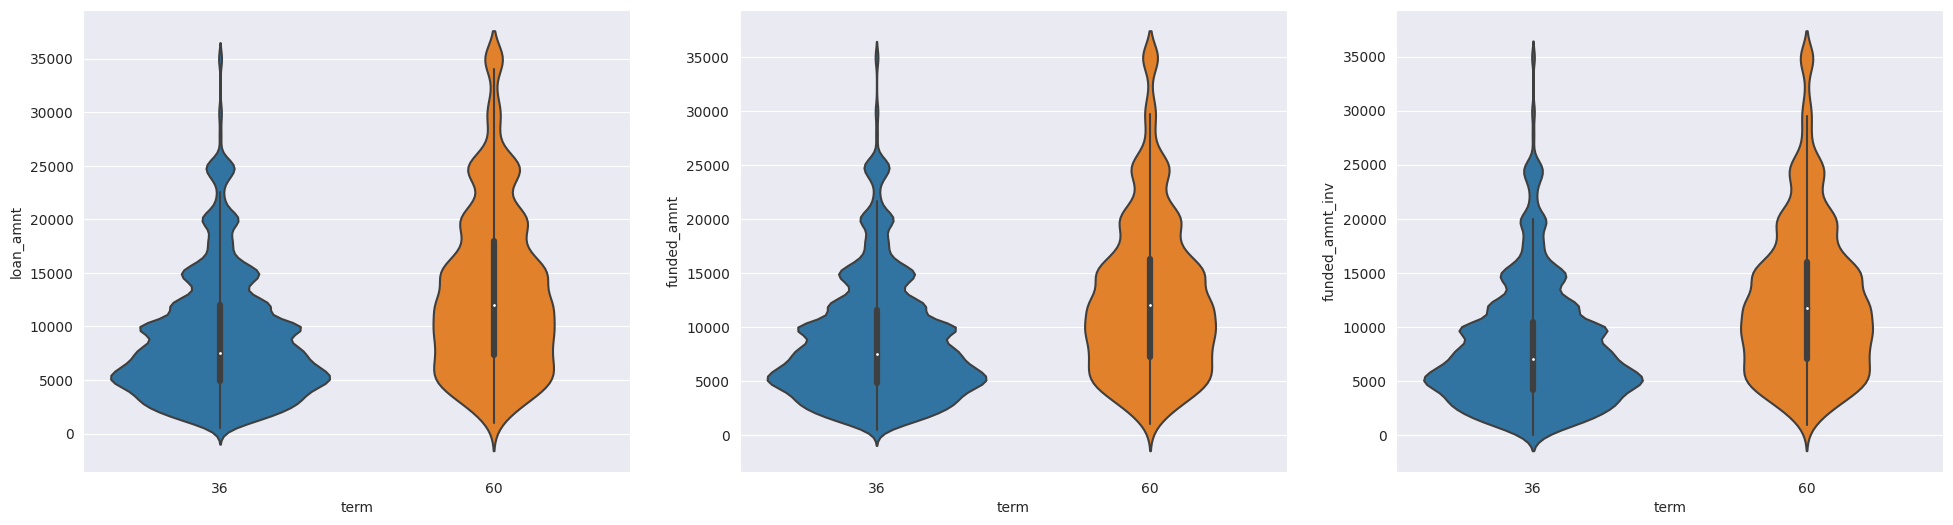

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
sns.violinplot(data=data_df, x='term', y='loan_amnt', ax=ax[0])
sns.violinplot(data=data_df, x='term', y='funded_amnt', ax=ax[1])
sns.violinplot(data=data_df, x='term', y='funded_amnt_inv', ax=ax[2])
plt.show()

#### Interest Rate

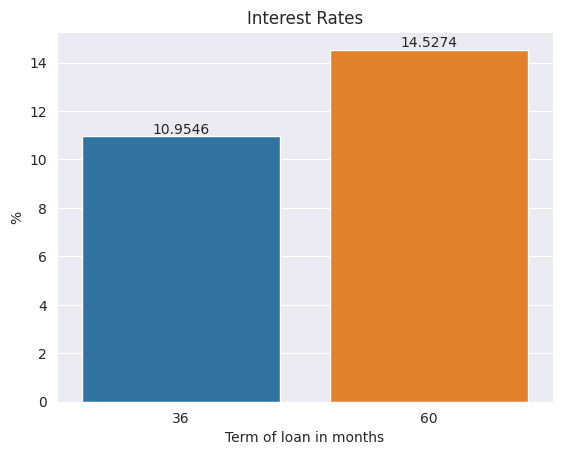

In [155]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='int_rate', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Term of loan in months")
plt.ylabel("%")
plt.show()

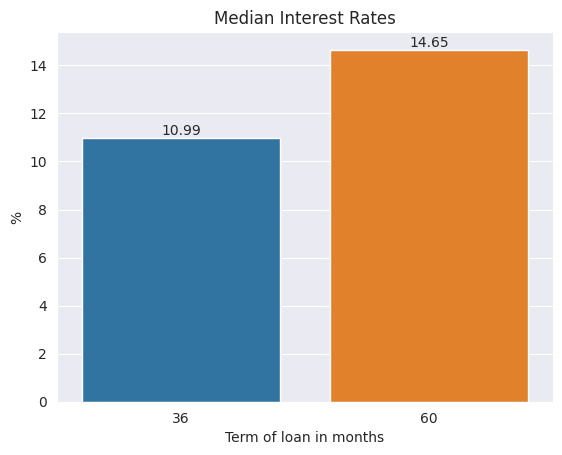

In [134]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='int_rate', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Median Interest Rates")
plt.xlabel("Term of loan in months")
plt.ylabel("%")
plt.show()

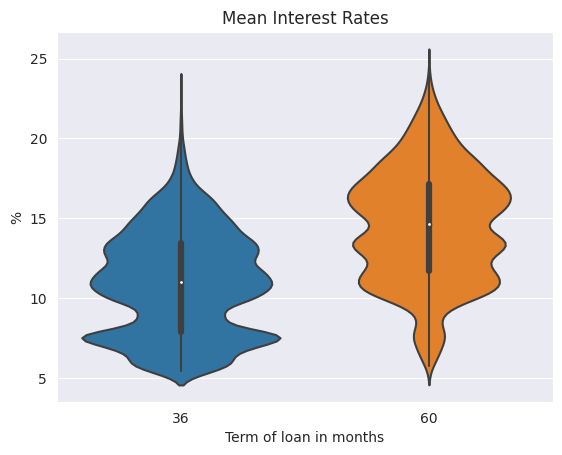

In [135]:
plt.figure()
sns.violinplot(data=data_df, x='term', y='int_rate')
plt.title("Mean Interest Rates")
plt.xlabel("Term of loan in months")
plt.ylabel("%")
plt.show()

#### Installment

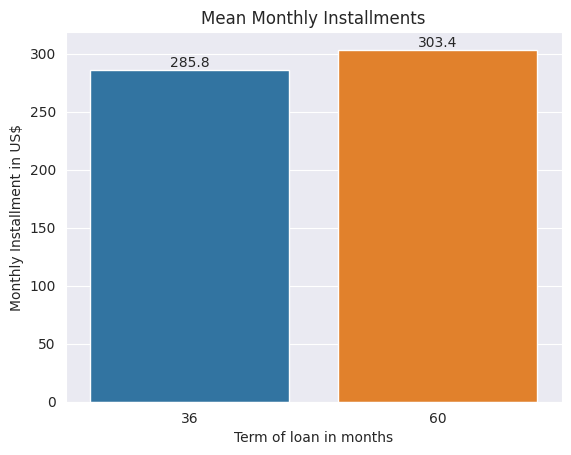

In [156]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='installment', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
plt.title("Mean Monthly Installments")
plt.xlabel("Term of loan in months")
plt.ylabel("Monthly Installment in US$")
plt.show()

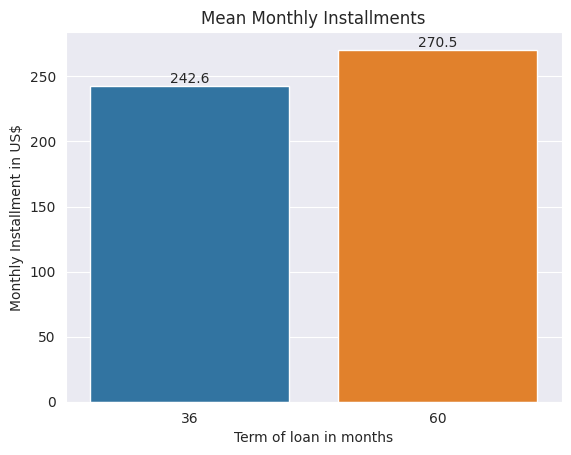

In [157]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='installment', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0], fmt="{:0.1f}")
plt.title("Mean Monthly Installments")
plt.xlabel("Term of loan in months")
plt.ylabel("Monthly Installment in US$")
plt.show()

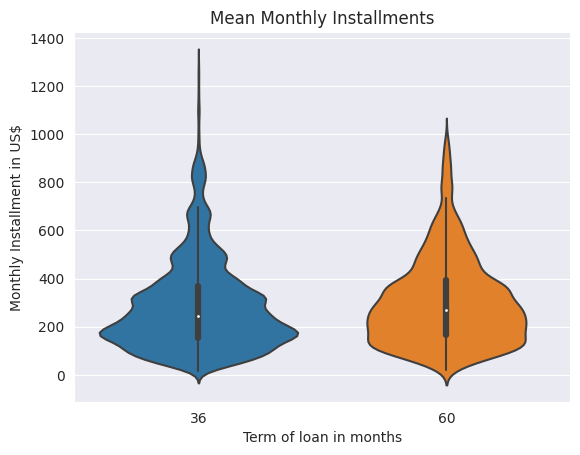

In [158]:
plt.figure()
ax = sns.violinplot(data=data_df, x='term', y='installment')
plt.title("Mean Monthly Installments")
plt.xlabel("Term of loan in months")
plt.ylabel("Monthly Installment in US$")
plt.show()

#### Grade

In [159]:
a = data_df.groupby(['term', 'grade'])['id'].count().reset_index()
aa = a.groupby(['grade'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='grade').drop_duplicates()
del aa
a.columns = ['term', 'grade', 'num_appln', 'total_grade']
a['percent_grade'] = a.num_appln * 100 / a.total_grade
a

,term,grade,num_appln,total_grade,percent_grade
0,36,A,8881,9229,96.229277
1,60,A,348,9229,3.770723
2,36,B,8321,10057,82.738391
3,60,B,1736,10057,17.261609
4,36,C,5234,6772,77.288836
5,60,C,1538,6772,22.711164
6,36,D,2890,4308,67.084494
7,60,D,1418,4308,32.915506
8,36,E,750,1985,37.783375
9,60,E,1235,1985,62.216625


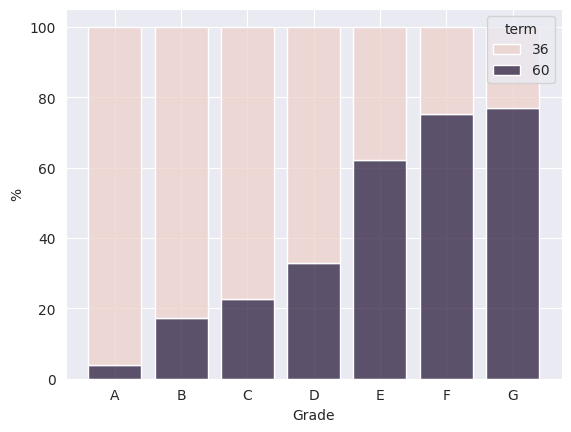

In [162]:
plt.figure()
sns.histplot(data=a, x='grade', weights='percent_grade', hue='term', multiple='stack', shrink=0.8)
plt.xlabel("Grade")
plt.ylabel('%')
plt.xticks(rotation=0)
plt.title("")
plt.show()

#### Debt-to-Income

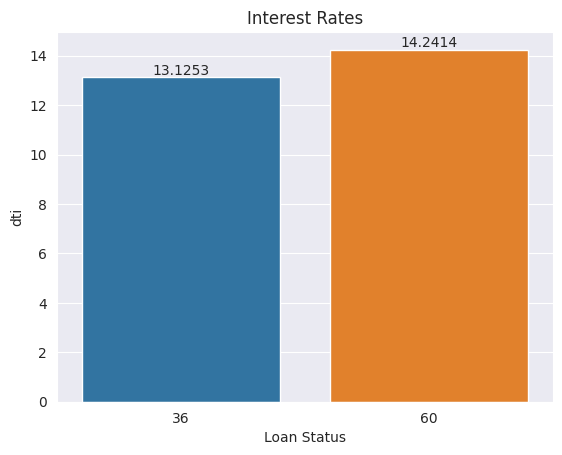

In [165]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='dti', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Loan Status")
# plt.ylabel("%")
plt.show()

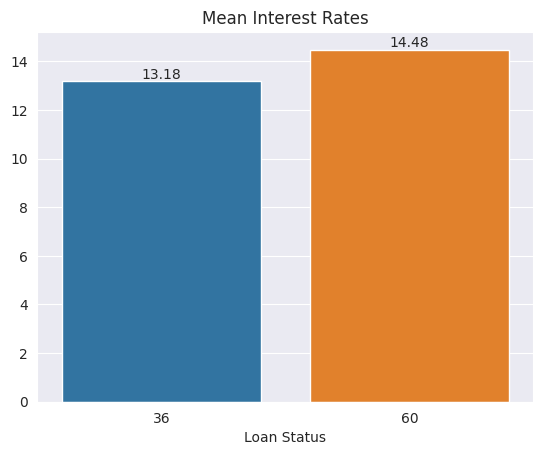

In [166]:
plt.figure()
ax = sns.barplot(data=data_df, x='term', y='dti', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Mean Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("")
plt.show()

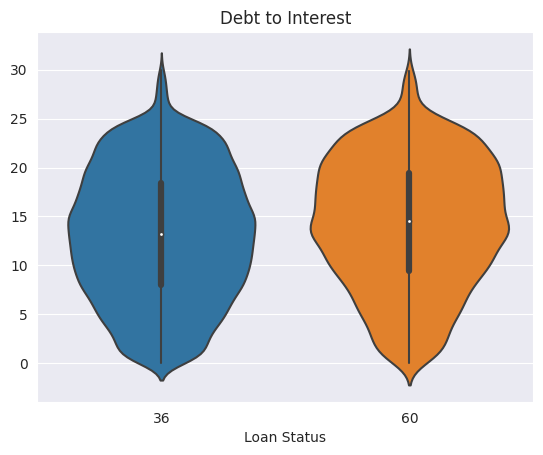

In [167]:
plt.figure()
sns.violinplot(data=data_df, x='term', y='dti')
# ax.bar_label(ax.containers[0])
plt.title("Debt to Interest")
plt.xlabel("Loan Status")
plt.ylabel("")
plt.show()

#### Address State

In [173]:
a = data_df.groupby(['term', 'addr_state'])['id'].count().reset_index()
aa = a.groupby(['addr_state'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='addr_state').drop_duplicates()
del aa
a.columns = ['term', 'addr_state', 'num_appln', 'total_state']
a['percent_state'] = a.num_appln * 100 / a.total_state
a = a.sort_values(by='total_state', ascending=False)
a

,term,addr_state,num_appln,total_state,percent_state
9,60,CA,1181,6001,19.680053
8,36,CA,4820,6001,80.319947
60,36,NY,2549,3143,81.100859
61,60,NY,594,3143,18.899141
19,60,FL,520,2447,21.250511
18,36,FL,1927,2447,78.749489
78,60,TX,414,2235,18.523490
77,36,TX,1821,2235,81.476510
54,36,NJ,1191,1518,78.458498
55,60,NJ,327,1518,21.541502


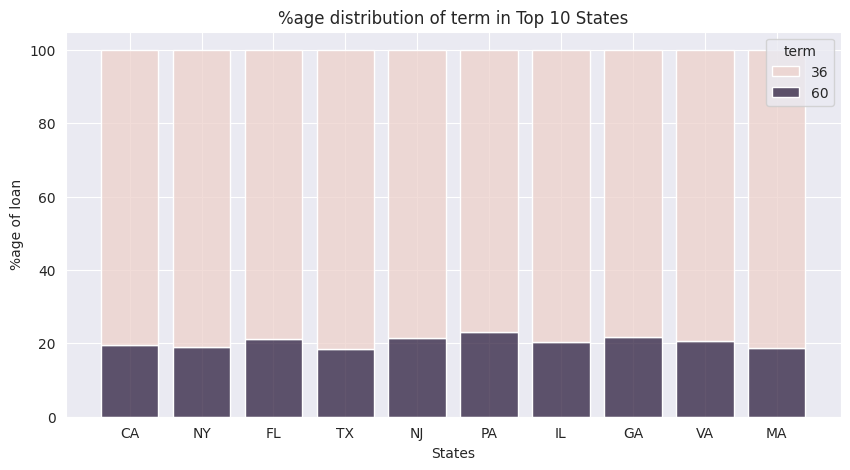

In [180]:
plt.figure(figsize=(10, 5))
# ax = sns.barplot(data=a.iloc[:10], x='addr_state', y='percent_state', hue='term')
# ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
# ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
sns.histplot(data=a.iloc[:20], x='addr_state', weights='percent_state',
             hue='term', multiple='stack', shrink=0.8)
plt.title('%age distribution of term in Top 10 States')
plt.xlabel('States')
plt.ylabel('%age of loan')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# del a

In [53]:
a = data_df.groupby(['loan_status', 'verification_status'])['id'].count().reset_index()
aa = a.groupby(['verification_status'])['id'].sum().reset_index()
a = a.merge(aa, how='inner', on='verification_status').drop_duplicates()
del aa
a.columns = ['term', 'addr_state', 'num_appln', 'total_state']
a['percent_state'] = a.num_appln * 100 / a.total_state
a = a.sort_values(by='total_state', ascending=False)
a

,term,addr_state,num_appln,total_state,percent_state
0,Charged Off,Not Verified,2106,15532,13.559104
1,Fully Paid,Not Verified,13426,15532,86.440896
4,Charged Off,Verified,1964,9272,21.182053
5,Fully Paid,Verified,7308,9272,78.817947
2,Charged Off,Source Verified,1385,8428,16.433318
3,Fully Paid,Source Verified,7043,8428,83.566682


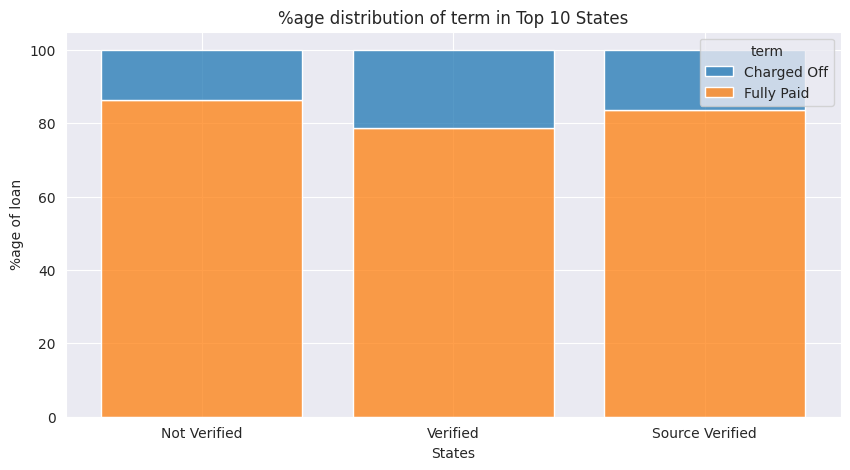

In [54]:
plt.figure(figsize=(10, 5))
# ax = sns.barplot(data=a.iloc[:10], x='addr_state', y='percent_state', hue='term')
# ax.bar_label(ax.containers[0], fmt="{:0.1f}%")
# ax.bar_label(ax.containers[1], fmt="{:0.1f}%")
sns.histplot(data=a.iloc[:20], x='addr_state', weights='percent_state',
             hue='term', multiple='stack', shrink=0.8)
plt.title('%age distribution of term in Top 10 States')
plt.xlabel('States')
plt.ylabel('%age of loan')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# del a